In [2]:
# Parte 1 - creo dataframe
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
from MJP.majority_portfolio_utilities_TV import * 

FILENAME = 'monthly_data.csv'
factors_df=pd.DataFrame({
    'factors': ['ag','beta','bm','cumret','dolvol6','gp','ill6','ns','size','volatility','acc'],
    'signs': [  -1.,  1.,   1.,    1.,     -1.,     1.,    1.,  -1.,  -1.,   -1.,   -1.],
    'wsigns':[  -1.,  1.,   1.,    1.,     -1.,     1.,    1.,  -1.,  -1.,   -1.,   -1.]
})

DATA_INIZIO = '2000-01-01'      # In futuro considerare periodi bull e bear
DATA_FINE = '2023-12-31'        # Quindi utilizzare sub periodi

df = create_df(FILENAME, factors_df['factors'].tolist(), DATA_INIZIO, DATA_FINE) # funzione sua
df['date']=pd.to_datetime(df['date']) 
print(f"DataFrame caricato: {df.shape[0]:,} righe, {df.shape[1]} colonne")
print(df.columns.tolist())

DataFrame caricato: 1,099,846 righe, 19 colonne
['PERMNO', 'date', 'RET', 'ns', 'me', 'size', 'me_lag', 'ag', 'gp', 'acc', 'bm', 'RF', 'Mkt_RF', 'RET_RF', 'cumret', 'dolvol6', 'ill6', 'volatility', 'beta']


In [3]:
# PARTE 2 - NORMALIZZO CON QUANTILE NORMALIZER

from sklearn.preprocessing import QuantileTransformer

factors_to_normalize = ['ns', 'size', 'ag', 'gp', 'acc', 'bm', 'ill6', 'volatility', 'beta', 'cumret', 'dolvol6']

# Elimina righe con NaN solo nelle colonne da normalizzare
df_clean = df.dropna(subset=factors_to_normalize)

# Applica Quantile normalization solo ai fattori
scaler = QuantileTransformer(output_distribution='uniform', random_state=0)
df_norm = df_clean.copy()
df_norm[factors_to_normalize] = scaler.fit_transform(df_clean[factors_to_normalize])

print("✅ df normalizzato su fattori:")
df_norm.head()

✅ df normalizzato su fattori:


,PERMNO,date,RET,ns,me,size,me_lag,ag,gp,acc,bm,RF,Mkt_RF,RET_RF,cumret,dolvol6,ill6,volatility,beta
0,10001,2000-01-31,-0.044118,0.552123,19.90625,0.089730,20.82500,0.429226,0.186763,0.098351,0.751966,0.0041,-0.0474,-0.048218,0.406036,0.051494,0.868132,0.039530,0.100142
1,10001,2000-02-29,0.015385,0.552123,20.21250,0.090958,19.90625,0.429226,0.186763,0.098351,0.746500,0.0043,0.0245,0.011085,0.449992,0.047740,0.875944,0.018688,0.100379
2,10001,2000-03-31,-0.015758,0.619632,19.71200,0.088813,20.21250,0.429226,0.186763,0.098351,0.754909,0.0047,0.0520,-0.020458,0.452531,0.047380,0.864058,0.018764,0.102204
3,10001,2000-04-30,0.011719,0.619632,19.94300,0.089905,19.71200,0.429226,0.186763,0.098351,0.751315,0.0046,-0.0640,0.007119,0.424543,0.044751,0.822586,0.018568,0.096001
4,10001,2000-05-31,-0.023166,0.619632,19.48100,0.087670,19.94300,0.429226,0.186763,0.098351,0.759141,0.0050,-0.0442,-0.028166,0.455732,0.040165,0.850747,0.018772,0.100983


In [4]:
# Parte 3 - inizializzazione della configurazione

# *** ATTENZIONE *** --> PRIMA MODIFICA, HO MESSO TRUE A WEIGHT

remove_outliers = False
inf, sup = None, None
MJ_configuration={
    'K' : 12, # holding_periods in months
    'lag' : 5, # 5 for june reallocation
    'factors' : factors_df['factors'].to_list(),
    'num_port' : 10, # number of portfolios
    'num_cat' : 6, # number of categorical variables to use per factor in mj #'num_cat': 6
    'weighting': True,
    'verbose': True,
    'n_jobs':-1,
    'mj_window':1,
    'method' : 'majority', # mean_rank, majority, 75q, 90q, lex, dlex
    'rolling_method':'profile',  ###'rank','vote','profile'
    'treat_na_mj':'median',
    'remove_outliers':remove_outliers,
    'inclusive':True,
    'fix_signs':True, # True: tieni fisso il numero di votanti ed il loro segno
    'all_voters_not_nan_on_reallocation':True,
    #### PARAMETRI UTILIZZATI SOLO SE fix_signs=False ####
    'min_voters':5,    
    'voting_window':6,
    'sign_voting_window':12,
    'p_threshold' : 0.1, 
    'delta_utility' : 0,
    'eliminations': 1,
    'players_batch_size': 5,
    'small': True
}
if remove_outliers:
    MJ_configuration['outliers']=[inf,sup]

if MJ_configuration['weighting']:
    MJ_configuration['default_voters']=factors_df['factors'].to_list()
    MJ_configuration['default_signs']=factors_df['wsigns'].to_list()
    compute='wmj'
elif not MJ_configuration['weighting']:
    MJ_configuration['default_voters']=factors_df['factors'].to_list()
    MJ_configuration['default_signs']=factors_df['signs'].to_list()
    compute='mj'

factors=factors_df['factors'].to_list() # salva separatamente la lista dei nomi dei fattori 

In [5]:
# Parte 4 - creazione portafogli single criteria e MJ

### COMPUTE SINGLE FACTOR STRATEGIES
portfolios, weighted_portfolios, portfolios_stock_reallocation = compute_factor_strategies(df_norm, MJ_configuration)
        # '2020-06-30': [list of tickers]       # Con pesi, uguale ma 'AAPL': 0.1           # 'AAPL': 2020-06-30': 'P3', '2021-06-30': 'P5'}
        # '2021-06-30': [list of tickers]
        # _ perché non considero weighted_portfolios al momento

### COMPUTE EQUAL WEIGHTED MJ STRATEGY
MJ_configuration['weighting']=False
MJ_portfolios, \
mj_voters, \
MJ_portfolios_stock_reallocation = compute_MJ_portfolio_strategy(df_norm, MJ_configuration)

portfolios['mj'] = MJ_portfolios['mj']
portfolios_stock_reallocation['mj'] = {}
portfolios_stock_reallocation['mj']['EW_turnover'] = MJ_portfolios_stock_reallocation['mj']

### COMPUTE VALUE WEIGHTED MJ STRATEGY
MJ_configuration['weighting']=True
MJ_weighted_portfolios, \
mj_voters, \
MJ_weighted_portfolios_stock_reallocation = compute_MJ_portfolio_strategy(df_norm, MJ_configuration)

weighted_portfolios['wmj'] = MJ_weighted_portfolios['wmj']
portfolios_stock_reallocation['wmj'] = {}
portfolios_stock_reallocation['wmj']['VW_turnover'] = MJ_weighted_portfolios_stock_reallocation['wmj']

'''
OUTPUT: 
portfolios = {
  'ns': DataFrame con port1...port10 costruiti su ns,
  'beta': ...,
  'bm': ...,
  ...
  'mj': DataFrame con port1...port10 creati con MJ
}
'''


"\nOUTPUT: \nportfolios = {\n  'ns': DataFrame con port1...port10 costruiti su ns,\n  'beta': ...,\n  'bm': ...,\n  ...\n  'mj': DataFrame con port1...port10 creati con MJ\n}\n"

In [6]:
# PARTE 6 - COMPUTE EW-VW MCDM STRATEGY

TOPSIS_portfolios, TOPSIS_portfolios_stock_reallocation = compute_mcdm_rolling_strategy(df_norm, 'topsis', MJ_configuration, weighting=False)
VIKOR_portfolios, VIKOR_portfolios_stock_reallocation = compute_mcdm_rolling_strategy(df_norm, 'vikor', MJ_configuration, weighting=False)
PROMETHEE_portfolios, PROMETHEE_portfolios_stock_reallocation = compute_mcdm_rolling_strategy(df_norm, 'promethee', MJ_configuration, weighting=False)

# inserisco EW mcdm in portfolios e reallocation
portfolios['topsis'] = TOPSIS_portfolios # gia' df
portfolios['vikor'] = VIKOR_portfolios
portfolios['promethee'] = PROMETHEE_portfolios

portfolios_stock_reallocation['topsis'] = TOPSIS_portfolios_stock_reallocation
portfolios_stock_reallocation['vikor'] = VIKOR_portfolios_stock_reallocation
portfolios_stock_reallocation['promethee'] = PROMETHEE_portfolios_stock_reallocation

### COMPUTE VW MCDM STRATEGY
TOPSIS_weighted_portfolios, TOPSIS_weighted_portfolios_stock_reallocation = compute_mcdm_rolling_strategy(df_norm, 'topsis', MJ_configuration, weighting=True)
VIKOR_weighted_portfolios, VIKOR_weighted_portfolios_stock_reallocation = compute_mcdm_rolling_strategy(df_norm, 'vikor', MJ_configuration, weighting=True)
PROMETHEE_weighted_portfolios, PROMETHEE_weighted_portfolios_stock_reallocation = compute_mcdm_rolling_strategy(df_norm, 'promethee', MJ_configuration, weighting=True)

# inserisco VW mcdm in portfolios e reallocation
weighted_portfolios['wtopsis'] = TOPSIS_weighted_portfolios
weighted_portfolios['wvikor'] = VIKOR_weighted_portfolios
weighted_portfolios['wpromethee'] = PROMETHEE_weighted_portfolios

portfolios_stock_reallocation['wtopsis'] = TOPSIS_weighted_portfolios_stock_reallocation
portfolios_stock_reallocation['wvikor'] = VIKOR_weighted_portfolios_stock_reallocation
portfolios_stock_reallocation['wpromethee'] = PROMETHEE_weighted_portfolios_stock_reallocation


In [7]:
metodi = list(portfolios.keys())                                                    ## Qua modificare per vedere i vari cosi da mettere nella tabella

best_portfolios = {}                                                                                                                   #    <--------------------------------

print("Studio dei rendimenti dei portafogli *port10* (EW) per ogni metodo:")
for metodo in metodi:
    df_metodo = portfolios[metodo]

    if 'port10' not in df_metodo.columns:
        print(f"⚠️ Attenzione: {metodo} non ha port10.")
        continue

    rendimento_port10 = df_metodo['port10'].mean()

    best_portfolios[metodo] = {
        'portafoglio': 'port10',
        'rendimento_medio': rendimento_port10
    }

for metodo, info in best_portfolios.items():
    print(f"{metodo.upper():<10} ➜ rendimento medio mensile EW_P10 = {info['rendimento_medio']:.4f}")

# Trova il metodo il cui port10 ha avuto il rendimento medio più alto
migliore_assoluto = max(best_portfolios.items(), key=lambda x: x[1]['rendimento_medio'])

metodo_top = migliore_assoluto[0]
rendimento_top = migliore_assoluto[1]['rendimento_medio']

print("*" * 50)
print(f"WINNER: Il metodo con il miglior PORT10 è: {metodo_top.upper()} con rendimento medio mensile di {rendimento_top:.4f}")
print("*" * 50)

metodi_w = list(weighted_portfolios.keys())

best_wportfolios = {}                                                                                                                   #    <--------------------------------

print("Studio dei rendimenti dei portafogli *port10* (VW) per ogni metodo:")
for metodo in metodi_w:
    df_metodo = weighted_portfolios[metodo]

    if 'port10' not in df_metodo.columns:
        print(f"⚠️ Attenzione: {metodo} non ha port10.")
        continue

    rendimento_port10 = df_metodo['port10'].mean()

    best_wportfolios[metodo] = {
        'portafoglio': 'port10',
        'rendimento_medio': rendimento_port10
    }

for metodo, info in best_wportfolios.items():
    print(f"{metodo.upper():<10} ➜ rendimento medio mensile VW_P10 = {info['rendimento_medio']:.4f}")

# Trova il metodo il cui port10 ha avuto il rendimento medio più alto
migliore_assoluto = max(best_wportfolios.items(), key=lambda x: x[1]['rendimento_medio'])

metodo_top = migliore_assoluto[0]
rendimento_top = migliore_assoluto[1]['rendimento_medio']

print("*" * 50)
print(f"WINNER: Il metodo con il miglior PORT10 (VW) è: {metodo_top.upper()} con rendimento medio mensile di {rendimento_top:.4f}")
print("*" * 50)


Studio dei rendimenti dei portafogli *port10* (EW) per ogni metodo:
AG         ➜ rendimento medio mensile EW_P10 = 0.0012
BETA       ➜ rendimento medio mensile EW_P10 = 0.0080
BM         ➜ rendimento medio mensile EW_P10 = 0.0180
CUMRET     ➜ rendimento medio mensile EW_P10 = 0.0051
DOLVOL6    ➜ rendimento medio mensile EW_P10 = 0.0064
GP         ➜ rendimento medio mensile EW_P10 = 0.0128
ILL6       ➜ rendimento medio mensile EW_P10 = 0.0181
NS         ➜ rendimento medio mensile EW_P10 = -0.0016
SIZE       ➜ rendimento medio mensile EW_P10 = 0.0071
VOLATILITY ➜ rendimento medio mensile EW_P10 = 0.0057
ACC        ➜ rendimento medio mensile EW_P10 = 0.0070
MJ         ➜ rendimento medio mensile EW_P10 = 0.0194
TOPSIS     ➜ rendimento medio mensile EW_P10 = 0.0185
VIKOR      ➜ rendimento medio mensile EW_P10 = 0.0138
PROMETHEE  ➜ rendimento medio mensile EW_P10 = 0.0191
**************************************************
WINNER: Il metodo con il miglior PORT10 è: MJ con rendimento medio men

In [8]:
# UGUALE MA CON LONG SHORT
metodi = list(portfolios.keys())

best_portfolios_LS = {}                                                                                                                   #    <--------------------------------

print("Studio dei rendimenti dei portafogli *long_short* (EW) per ogni metodo:")
for metodo in metodi:
    df_metodo = portfolios[metodo]

    if 'long_short' not in df_metodo.columns:
        print(f"⚠️ Attenzione: {metodo} non ha long_short.")
        continue

    rendimento_LS = df_metodo['long_short'].mean()

    best_portfolios_LS[metodo] = {
        'portafoglio': 'long_short',
        'rendimento_medio': rendimento_LS
    }

for metodo, info in best_portfolios_LS.items():
    print(f"{metodo.upper():<10} ➜ rendimento medio mensile EW_LS = {info['rendimento_medio']:.4f}")

# Trova il metodo il cui LS ha avuto il rendimento medio più alto
migliore_assoluto_LS = max(best_portfolios_LS.items(), key=lambda x: x[1]['rendimento_medio'])

metodo_top_LS = migliore_assoluto_LS[0]
rendimento_top_LS = migliore_assoluto_LS[1]['rendimento_medio']

print("*" * 50)
print(f"WINNER: Il metodo con il miglior longshort è: {metodo_top_LS.upper()} con rendimento medio mensile di {rendimento_top_LS:.4f}")
print("*" * 50)

# UGUALE MA CON LONG SHORT
metodi_w = list(weighted_portfolios.keys())

best_wportfolios_WLS = {}                                                                                                                   #    <--------------------------------

print("Studio dei rendimenti dei portafogli *long_short* (VW) per ogni metodo:")
for metodo in metodi_w:
    df_metodo = weighted_portfolios[metodo]

    if 'long_short' not in df_metodo.columns:
        print(f"⚠️ Attenzione: {metodo} non ha long_short.")
        continue

    rendimento_WLS = df_metodo['long_short'].mean()

    best_wportfolios_WLS[metodo] = {
        'portafoglio': 'long_short',
        'rendimento_medio': rendimento_WLS
    }

for metodo, info in best_wportfolios_WLS.items():
    print(f"{metodo.upper():<10} ➜ rendimento medio mensile VW_LS = {info['rendimento_medio']:.4f}")

# Trova il metodo il cui LS ha avuto il rendimento medio più alto
migliore_assoluto_WLS = max(best_wportfolios_WLS.items(), key=lambda x: x[1]['rendimento_medio'])

metodo_top_WLS = migliore_assoluto_WLS[0]
rendimento_top_WLS = migliore_assoluto_WLS[1]['rendimento_medio']

print("*" * 50)
print(f"WINNER: Il metodo con il miglior longshort è: {metodo_top_WLS.upper()} con rendimento medio mensile di {rendimento_top_WLS:.4f}")
print("*" * 50)

Studio dei rendimenti dei portafogli *long_short* (EW) per ogni metodo:
AG         ➜ rendimento medio mensile EW_LS = 0.0115
BETA       ➜ rendimento medio mensile EW_LS = 0.0012
BM         ➜ rendimento medio mensile EW_LS = 0.0114
CUMRET     ➜ rendimento medio mensile EW_LS = -0.0071
DOLVOL6    ➜ rendimento medio mensile EW_LS = 0.0127
GP         ➜ rendimento medio mensile EW_LS = 0.0084
ILL6       ➜ rendimento medio mensile EW_LS = 0.0113
NS         ➜ rendimento medio mensile EW_LS = 0.0143
SIZE       ➜ rendimento medio mensile EW_LS = 0.0095
VOLATILITY ➜ rendimento medio mensile EW_LS = 0.0033
ACC        ➜ rendimento medio mensile EW_LS = 0.0031
MJ         ➜ rendimento medio mensile EW_LS = 0.0169
TOPSIS     ➜ rendimento medio mensile EW_LS = 0.0157
VIKOR      ➜ rendimento medio mensile EW_LS = 0.0124
PROMETHEE  ➜ rendimento medio mensile EW_LS = 0.0162
**************************************************
WINNER: Il metodo con il miglior longshort è: MJ con rendimento medio mensile di 

In [9]:
# PARTE 9 - Confronto statistico su sharpe-ratio usando bootstrap 
################################################################################# P10 #################################################################################


def calculate_sharpe_ratio(returns_series, risk_free_rate=0.0):

    '''
    Calcola lo Sharpe Ratio annualizzato.
    Assume returns_series sono rendimenti mensili.
    '''

    mean_return = returns_series.mean() * 12 # Rendimento medio annualizzato
    std_dev = returns_series.std() * np.sqrt(12) # Deviazione standard annualizzata (volatilità)

    annualized_risk_free_rate = risk_free_rate * 12

    if std_dev == 0:
        return np.nan
    return (mean_return - annualized_risk_free_rate) / std_dev

def calculate_sortino_ratio(returns_series, mar_monthly: float = 0.0):
    """
    Sortino Ratio annualizzato.
    - returns_series: rendimenti MENSILI
    - mar_monthly: Minimum Acceptable Return MENSILE (default 0.0). 
      Se vuoi usarlo come risk-free mensile, passalo qui.
    """
    # Numeratore: extra-mean rispetto al MAR, annualizzato
    excess_mean_ann = (returns_series.mean() - mar_monthly) * 12

    # Downside deviation mensile: sqrt( mean( min(0, r - MAR)^2 ) )
    downside_diff = np.minimum(0.0, returns_series - mar_monthly)
    downside_dev_monthly = np.sqrt((downside_diff ** 2).mean())

    # Annualizzazione della downside deviation
    downside_dev_ann = downside_dev_monthly * np.sqrt(12)

    if downside_dev_ann == 0 or np.isnan(downside_dev_ann):
        return np.nan
    return excess_mean_ann / downside_dev_ann

def compute_portfolio_stats(best_portfolios, portfolios_dict, mar_monthly: float = 0.0):
    risultati = []

    for metodo, info in best_portfolios.items():
        portafoglio = info['portafoglio']
        serie = portfolios_dict[metodo][portafoglio]

        rendimento_medio = serie.mean()
        volatilita = serie.std()
        sharpe = calculate_sharpe_ratio(serie)  # usa risk_free mensile = 0.0 di default
        sortino = calculate_sortino_ratio(serie, mar_monthly=mar_monthly)

        # Calcolo drawdown
        cumulative = (1 + serie).cumprod()
        peak = cumulative.cummax()
        drawdown = (cumulative - peak) / peak
        max_drawdown = abs(drawdown.min())

        risultati.append({
            'Metodo': metodo,
            'Portafoglio': portafoglio,
            'Rendimento medio': rendimento_medio,
            'Volatilità': volatilita,
            'Sharpe Ratio': sharpe,
            'Sortino Ratio': sortino,
            'Max Drawdown': max_drawdown
        })

    return pd.DataFrame(risultati)

print("\n--- Statistiche dei portafogli basandosi su P10 ---")
stats_ew = compute_portfolio_stats(best_portfolios, portfolios)
stats_vw = compute_portfolio_stats(best_wportfolios, weighted_portfolios)

print("Statistiche portafogli Equal Weighted (EW):")
print(stats_ew.round(4))
print("\nStatistiche portafogli Value Weighted (VW):")
print(stats_vw.round(4))

print("\n--- Statistiche dei portafogli basandosi su LS ---")
stats_ew_LS = compute_portfolio_stats(best_portfolios_LS, portfolios)
stats_vw_LS = compute_portfolio_stats(best_wportfolios_WLS, weighted_portfolios)

print("Statistiche portafogli Equal Weighted (EW):")
print(stats_ew_LS.round(4))
print("\nStatistiche portafogli Value Weighted (VW):")
print(stats_vw_LS.round(4))


--- Statistiche dei portafogli basandosi su P10 ---
Statistiche portafogli Equal Weighted (EW):
        Metodo Portafoglio  Rendimento medio  Volatilità  Sharpe Ratio  \
0           ag      port10            0.0012      0.0834        0.0519   
1         beta      port10            0.0080      0.1131        0.2448   
2           bm      port10            0.0180      0.0868        0.7180   
3       cumret      port10            0.0051      0.0748        0.2346   
4      dolvol6      port10            0.0064      0.0597        0.3683   
5           gp      port10            0.0128      0.0674        0.6564   
6         ill6      port10            0.0181      0.0776        0.8103   
7           ns      port10           -0.0016      0.0957       -0.0574   
8         size      port10            0.0071      0.0497        0.4976   
9   volatility      port10            0.0057      0.1067        0.1842   
10         acc      port10            0.0070      0.0798        0.3057   
11          mj 

In [10]:
def bootstrap_sharpe_comparison_block(returns1, returns2, num_bootstrap_samples=2000,

    block_size=6, risk_free_rate=0.0):
    """

    Confronta gli Sharpe Ratio di due serie di rendimenti usando il block bootstrap.

    Restituisce la proporzione di volte che Sharpe1 > Sharpe2 (p-value unilaterale).

    Args:

    returns1 (pd.Series): Serie di rendimenti del primo portafoglio.

    returns2 (pd.Series): Serie di rendimenti del secondo portafoglio.

    num_bootstrap_samples (int): Numero di simulazioni bootstrap da eseguire.

    block_size (int): La dimensione del blocco di rendimenti da campionare.

    risk_free_rate (float): Tasso di rendimento risk-free mensile.

    """

    sharpes_diff = []
    n = len(returns1)

    # Calcola il numero di blocchi disponibili
    num_blocks = n // block_size
    if num_blocks == 0:
        print("Errore: la dimensione del blocco è maggiore della lunghezza dei dati.")
        return np.nan


    for _ in range(num_bootstrap_samples):

    # *** MODIFICA: Campionamento con block bootstrap ***
    # 1. Campiona gli INDICI dei blocchi con reinserimento
        block_indices = np.random.choice(num_blocks, size=num_blocks, replace=True)

    # 2. Ricostruisci le serie di rendimenti concatenando i blocchi campionati

        sample1 = np.empty(0)
        sample2 = np.empty(0)
        for idx in block_indices:
            start_idx = idx * block_size
            end_idx = start_idx + block_size
            sample1 = np.concatenate([sample1, returns1.iloc[start_idx:end_idx]])
            sample2 = np.concatenate([sample2, returns2.iloc[start_idx:end_idx]])

        # Assicura che la lunghezza del campione sia esattamente la stessa dell'originale
        sample1 = sample1[:n]
        sample2 = sample2[:n]

        # *** FINE MODIFICA ***

        sharpe1 = calculate_sharpe_ratio(pd.Series(sample1), risk_free_rate)
        sharpe2 = calculate_sharpe_ratio(pd.Series(sample2), risk_free_rate)


        if not np.isnan(sharpe1) and not np.isnan(sharpe2):
            sharpes_diff.append(sharpe1 - sharpe2)


    if not sharpes_diff:
        return np.nan

    p_value_one_sided = np.sum(np.array(sharpes_diff) <= 0) / len(sharpes_diff)

    return p_value_one_sided


# --- Applicazione ---
print("\n--- Confronto Statistico degli Sharpe Ratio basandoci su P10 (WMJ vs Altri VW) ---")
# Tasso risk-free mensile (assumo 0 per semplicità ) --> giustificare durante tesi
RISK_FREE_MONTHLY = 0.0

wmj_port_name = best_wportfolios['wmj']['portafoglio']
wmj_returns_series = weighted_portfolios['wmj'][wmj_port_name]

for metodo in [k for k in weighted_portfolios.keys() if k != 'wmj']:
    other_port_name = best_wportfolios[metodo]['portafoglio']
    other_returns_series = weighted_portfolios[metodo][other_port_name]

    min_len = min(len(wmj_returns_series), len(other_returns_series))
    wmj_sample_returns = wmj_returns_series.iloc[:min_len]
    other_sample_returns = other_returns_series.iloc[:min_len]

    # Chiamo la funzione
    p_value = bootstrap_sharpe_comparison_block(wmj_sample_returns, other_sample_returns, num_bootstrap_samples=2000, risk_free_rate=RISK_FREE_MONTHLY)

    # Interpretazione del p-value   
    alpha = 0.05 # Livello di significatività

    print(f"\nConfronto WMJ vs {metodo.upper()} - P10:")
    if p_value < alpha:
        print(f"La performance risk-adjusted di WMJ è STATISTICAMENTE SUPERIORE a quella di {metodo.upper()} (p-value = {p_value:.4f})")
    else:
        print(f"Non c'è una differenza statisticamente significativa nella performance risk-adjusted tra WMJ e {metodo.upper()} (p-value = {p_value:.4f})")


######################################################################## ORA UGUALE MA SU LONG-SHORT ######################################################################
# --- Applicazione ---
print("\n--- Confronto Statistico degli Sharpe Ratio basandoci su LS (WMJ vs Altri VW) ---")
# Tasso risk-free mensile (assumo 0 per semplicità ) --> giustificare durante tesi
RISK_FREE_MONTHLY = 0.0

wmj_port_name = best_wportfolios_WLS['wmj']['portafoglio']
wmj_returns_series = weighted_portfolios['wmj'][wmj_port_name]

for metodo in [k for k in weighted_portfolios.keys() if k != 'wmj']:
    other_port_name = best_wportfolios_WLS[metodo]['portafoglio']
    other_returns_series = weighted_portfolios[metodo][other_port_name]

    min_len = min(len(wmj_returns_series), len(other_returns_series))
    wmj_sample_returns = wmj_returns_series.iloc[:min_len]
    other_sample_returns = other_returns_series.iloc[:min_len]

    # Chiamo la funzione
    p_value = bootstrap_sharpe_comparison_block(wmj_sample_returns, other_sample_returns, num_bootstrap_samples=2000, risk_free_rate=RISK_FREE_MONTHLY)

    # Interpretazione del p-value   
    alpha = 0.05 # Livello di significatività

    print(f"\nConfronto WMJ vs {metodo.upper()} - LS:")
    if p_value < alpha:
        print(f"La performance risk-adjusted di WMJ è STATISTICAMENTE SUPERIORE a quella di {metodo.upper()} (p-value = {p_value:.4f})")
    else:
        print(f"Non c'è una differenza statisticamente significativa nella performance risk-adjusted tra WMJ e {metodo.upper()} (p-value = {p_value:.4f})")


# Dai risultati, wmj è tra i portafogli più efficienti (ottimo trade-off rendimento/rischio) 


--- Confronto Statistico degli Sharpe Ratio basandoci su P10 (WMJ vs Altri VW) ---

Confronto WMJ vs AG - P10:
La performance risk-adjusted di WMJ è STATISTICAMENTE SUPERIORE a quella di AG (p-value = 0.0000)

Confronto WMJ vs BETA - P10:
La performance risk-adjusted di WMJ è STATISTICAMENTE SUPERIORE a quella di BETA (p-value = 0.0000)

Confronto WMJ vs BM - P10:
La performance risk-adjusted di WMJ è STATISTICAMENTE SUPERIORE a quella di BM (p-value = 0.0085)

Confronto WMJ vs CUMRET - P10:
La performance risk-adjusted di WMJ è STATISTICAMENTE SUPERIORE a quella di CUMRET (p-value = 0.0010)

Confronto WMJ vs DOLVOL6 - P10:
La performance risk-adjusted di WMJ è STATISTICAMENTE SUPERIORE a quella di DOLVOL6 (p-value = 0.0205)

Confronto WMJ vs GP - P10:
Non c'è una differenza statisticamente significativa nella performance risk-adjusted tra WMJ e GP (p-value = 0.0725)

Confronto WMJ vs ILL6 - P10:
Non c'è una differenza statisticamente significativa nella performance risk-adjusted tra 

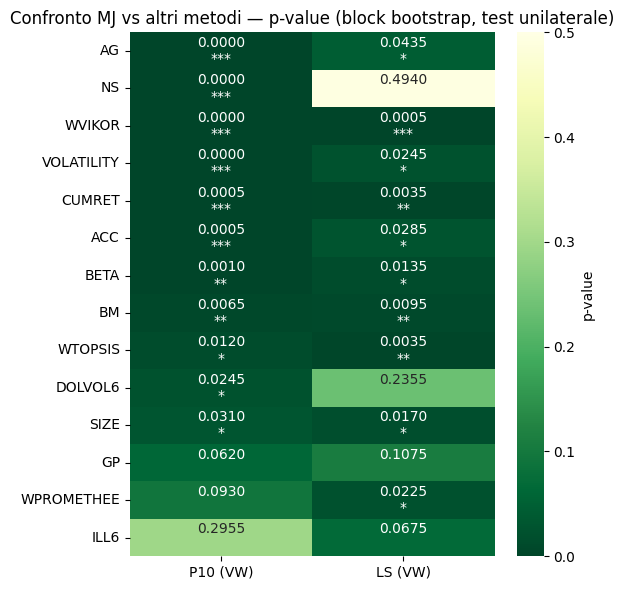

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pvals_p10_vw = {
    "AG": 0.0000, "BETA": 0.0010, "BM": 0.0065, "CUMRET": 0.0005,
    "DOLVOL6": 0.0245, "GP": 0.0620, "ILL6": 0.2955, "NS": 0.0000,
    "SIZE": 0.0310, "VOLATILITY": 0.0000, "ACC": 0.0005,
    "WTOPSIS": 0.0120, "WVIKOR": 0.0000, "WPROMETHEE": 0.0930
}

pvals_ls_vw = {
    "AG": 0.0435, "BETA": 0.0135, "BM": 0.0095, "CUMRET": 0.0035,
    "DOLVOL6": 0.2355, "GP": 0.1075, "ILL6": 0.0675, "NS": 0.4940,
    "SIZE": 0.0170, "VOLATILITY": 0.0245, "ACC": 0.0285,
    "WTOPSIS": 0.0035, "WVIKOR": 0.0005, "WPROMETHEE": 0.0225
}

# Allineo l’ordine dei metodi
methods = list(pvals_p10_vw.keys())
assert methods == list(pvals_ls_vw.keys())

# DataFrame largo: righe = metodi, colonne = configurazioni
df_pvalues = pd.DataFrame({
    "P10 (VW)": [pvals_p10_vw[m] for m in methods],
    "LS (VW)":  [pvals_ls_vw[m]  for m in methods],
}, index=methods)

# Opzionale: ordina per P10 p-value crescente (più “verdi” in alto)
df_pvalues = df_pvalues.sort_values(by="P10 (VW)")

# Mappa annotazioni: p-value + stelle
def stars(p):
    if p < 0.001: return "***"
    if p < 0.01:  return "**"
    if p < 0.05:  return "*"
    return ""

annot = df_pvalues.applymap(lambda p: f"{p:.4f}\n{stars(p)}")

# Heatmap
plt.figure(figsize=(6, max(6, 0.35*len(df_pvalues))))
ax = sns.heatmap(
    df_pvalues,
    annot=annot,
    fmt="",          # il testo in 'annot' è già formattato
    cmap="YlGn_r",   # verde = p basso (significativo)
    vmin=0.0, vmax=0.5,
    cbar_kws={"label": "p-value"}
)
ax.set_title("Confronto MJ vs altri metodi — p-value (block bootstrap, test unilaterale)")
plt.tight_layout()
plt.savefig("heatmap_pvalues_wmj.png", dpi=200)
plt.show()

In [12]:
from scipy.stats import ttest_rel, wilcoxon, shapiro
from statsmodels.stats.multitest import multipletests
import numpy as np
import pandas as pd

def comprehensive_comparison_test(series_a, series_b, name_a="WMJ", name_b="OTHER", alpha=0.05):
    """
    Esegue test sia parametrici che non-parametrici per confrontare due serie.
    """
    # Allineamento
    idx = series_a.index.intersection(series_b.index)
    a = series_a.loc[idx].dropna()
    b = series_b.loc[idx].dropna()
    idx = a.index.intersection(b.index)
    a = a.loc[idx]
    b = b.loc[idx]
    
    if len(a) < 10:
        return {
            'n_observations': len(a),
            'warning': f"Troppo poche osservazioni ({len(a)})"
        }
    
    # Calcola differenze
    differences = a - b
    
    # Test di normalità
    _, normality_p = shapiro(differences) if len(differences) >= 3 else (None, None)
    is_normal = normality_p > 0.05 if normality_p is not None else False
    
    # T-test parametrico
    t_stat, t_p = ttest_rel(a, b)
    
    # Test non-parametrico di Wilcoxon (più robusto)
    try:
        w_stat, w_p = wilcoxon(differences, alternative='two-sided')
    except:
        w_stat, w_p = np.nan, np.nan
    
    # Statistiche descrittive
    mean_a = a.mean()
    mean_b = b.mean()
    mean_diff = differences.mean()
    median_diff = differences.median()
    std_diff = differences.std()
    
    # Effect size (Cohen's d)
    pooled_std = np.sqrt((a.var() + b.var()) / 2)
    cohens_d = mean_diff / pooled_std if pooled_std > 0 else np.nan
    
    return {
        'n_observations': len(a),
        'mean_a': mean_a,
        'mean_b': mean_b,
        'mean_difference': mean_diff,
        'median_difference': median_diff,
        'std_difference': std_diff,
        'cohens_d': cohens_d,
        'normality_p': normality_p,
        'is_normal': is_normal,
        't_statistic': t_stat,
        't_p_value': t_p,
        'wilcoxon_statistic': w_stat,
        'wilcoxon_p_value': w_p,
        't_significant': t_p < alpha,
        'wilcoxon_significant': w_p < alpha,
        'recommended_test': 'wilcoxon' if not is_normal else 't_test'
    }

def perform_multiple_comparisons_analysis(wmj_returns, other_portfolios, alpha=0.05, 
                                        correction_method='holm'):
    """
    Esegue test multipli con correzione per confronti multipli.
    """
    results = {}
    methods = [m for m in other_portfolios.keys() if m != 'wmj']
    
    # Raccogli tutti i p-value
    t_p_values = []
    w_p_values = []
    
    for method_name in methods:
        other_returns = other_portfolios[method_name]
        result = comprehensive_comparison_test(
            wmj_returns, other_returns, "WMJ", method_name.upper(), alpha
        )
        results[method_name] = result
        
        if 'warning' not in result:
            t_p_values.append(result['t_p_value'])
            w_p_values.append(result['wilcoxon_p_value'])
        else:
            t_p_values.append(1.0)  # Non significativo per metodi con warning
            w_p_values.append(1.0)
    
    # Correzione per test multipli
    t_corrected = multipletests(t_p_values, alpha=alpha, method=correction_method)
    w_corrected = multipletests(w_p_values, alpha=alpha, method=correction_method)
    
    # Aggiungi correzioni ai risultati
    for i, method_name in enumerate(methods):
        if 'warning' not in results[method_name]:
            results[method_name]['t_p_corrected'] = t_corrected[1][i]
            results[method_name]['wilcoxon_p_corrected'] = w_corrected[1][i]
            results[method_name]['t_significant_corrected'] = t_corrected[0][i]
            results[method_name]['wilcoxon_significant_corrected'] = w_corrected[0][i]
    
    return results, correction_method

def print_comprehensive_results(results, title, correction_method=None, alpha=0.05):
    """
    Stampa risultati comprensivi con raccomandazioni.
    """
    print(f"\n{'='*80}")
    print(f"{title}")
    print(f"{'='*80}")
    
    # Header
    header = f"{'Metodo':<12} {'n':<4} {'T-test':<8} {'Wilcoxon':<9} {'Raccomandato':<12} {'Effect Size':<11} {'Note'}"
    print(header)
    print("-" * len(header))
    
    significant_methods = []
    
    for method, result in results.items():
        if 'warning' in result:
            print(f"{method.upper():<12} {result['n_observations']:<4} {'N/A':<8} {'N/A':<9} {'N/A':<12} {'N/A':<11} {result['warning']}")
            continue
        
        method_label = method.upper()
        
        # Scegli il test raccomandato
        if result['recommended_test'] == 'wilcoxon':
            main_p = result['wilcoxon_p_corrected'] if correction_method else result['wilcoxon_p_value']
            is_significant = main_p < alpha
            test_symbol = "W" if is_significant else "w"
        else:
            main_p = result['t_p_corrected'] if correction_method else result['t_p_value']
            is_significant = main_p < alpha
            test_symbol = "T" if is_significant else "t"
        
        # Effect size interpretation
        d = abs(result['cohens_d'])
        if d >= 0.8:
            effect = "Grande"
        elif d >= 0.5:
            effect = "Medio"  
        elif d >= 0.2:
            effect = "Piccolo"
        else:
            effect = "Trascurabile"
        
        # Note
        note = ""
        if not result['is_normal']:
            note += "Non-norm"
        if result['mean_difference'] > 0:
            note += " WMJ>" + method_label[:3]
        else:
            note += " WMJ<" + method_label[:3]
        
        t_p_display = f"{result['t_p_value']:.4f}"
        w_p_display = f"{result['wilcoxon_p_value']:.4f}"
        sig_symbol = "✅" if is_significant else "➖"
        
        print(f"{method_label:<12} {result['n_observations']:<4} {t_p_display:<8} {w_p_display:<9} "
              f"{test_symbol+sig_symbol:<12} {effect:<11} {note}")
        
        if is_significant:
            significant_methods.append(method_label)
    
    print(f"\n🎯 WMJ significativamente superiore a: {significant_methods}")
    print(f"📊 Test raccomandato: Wilcoxon (dati non-normali)")
    if correction_method:
        print(f"🔧 Correzione applicata: {correction_method}")

# ==================== APPLICAZIONE ======================

alpha = 0.05

# P10 Analysis
print("ANALISI STATISTICA ROBUSTA: P10 VW")
wmj_ret_p10 = weighted_portfolios['wmj'][best_wportfolios['wmj']['portafoglio']]
other_portfolios_p10 = {
    method: weighted_portfolios[method][best_wportfolios[method]['portafoglio']]
    for method in weighted_portfolios.keys() if method != 'wmj'
}

results_p10, correction_method = perform_multiple_comparisons_analysis(
    wmj_ret_p10, other_portfolios_p10, alpha, 'holm'
)
print_comprehensive_results(results_p10, "P10 VW: WMJ vs Altri Metodi (Test Robusti)", correction_method, alpha)

# LS Analysis  
print("\n\nANALISI STATISTICA ROBUSTA: LS VW")
wmj_ret_ls = weighted_portfolios['wmj'][best_wportfolios_WLS['wmj']['portafoglio']]
other_portfolios_ls = {
    method: weighted_portfolios[method][best_wportfolios_WLS[method]['portafoglio']]
    for method in weighted_portfolios.keys() if method != 'wmj'
}

results_ls, correction_method = perform_multiple_comparisons_analysis(
    wmj_ret_ls, other_portfolios_ls, alpha, 'holm'
)
print_comprehensive_results(results_ls, "LS VW: WMJ vs Altri Metodi (Test Robusti)", correction_method, alpha)

# Summary insight
print(f"\n{'='*80}")
print("📈 RIEPILOGO INSIGHTS")
print(f"{'='*80}")
print("• I rendimenti finanziari raramente seguono distribuzione normale")
print("• Il test di Wilcoxon è più appropriato per questi dati") 
print("• La correzione di Holm controlla il tasso di errore di Tipo I nei test multipli")
print("• L'effect size (Cohen's d) quantifica la dimensione pratica delle differenze")
print("• WMJ sembra performare meglio nella strategia P10 che in Long-Short")

ANALISI STATISTICA ROBUSTA: P10 VW

P10 VW: WMJ vs Altri Metodi (Test Robusti)
Metodo       n    T-test   Wilcoxon  Raccomandato Effect Size Note
------------------------------------------------------------------
AG           282  0.0000   0.0001    W✅           Trascurabile Non-norm WMJ>AG
BETA         282  0.1010   0.0682    w➖           Trascurabile Non-norm WMJ>BET
BM           282  0.1251   0.0701    w➖           Trascurabile Non-norm WMJ>BM
CUMRET       282  0.0050   0.0027    W✅           Trascurabile Non-norm WMJ>CUM
DOLVOL6      282  0.0003   0.0017    W✅           Trascurabile Non-norm WMJ>DOL
GP           282  0.0031   0.0067    T✅           Trascurabile  WMJ>GP
ILL6         282  0.2275   0.2811    w➖           Trascurabile Non-norm WMJ>ILL
NS           282  0.0000   0.0000    W✅           Piccolo     Non-norm WMJ>NS
SIZE         282  0.0004   0.0022    W✅           Trascurabile Non-norm WMJ>SIZ
VOLATILITY   282  0.0124   0.0048    W✅           Trascurabile Non-norm WMJ>VOL


In [13]:
def calculate_sortino_ratio(returns_series, risk_free_rate=RISK_FREE_MONTHLY):
    """
    Calcola il Sortino Ratio annualizzato.
    Assume returns_series sono rendimenti mensili.
    """
    # Rendimenti sotto il target (risk_free_rate mensile)
    excess_returns = returns_series - risk_free_rate
    negative_excess_returns = excess_returns[excess_returns < 0]
    
    downside_deviation = negative_excess_returns.std() * np.sqrt(12) # Annualizza
    
    mean_return = returns_series.mean() * 12 # Annualizza
    annualized_risk_free_rate = risk_free_rate * 12

    if downside_deviation == 0 or np.isnan(downside_deviation): # Gestisci il caso di deviazione standard zero o NaN
        return np.nan
    return (mean_return - annualized_risk_free_rate) / downside_deviation

def find_best_portfolio_by_metric_P10(portfolios_dict, metric_name, metric_calc_func=None, higher_is_better=True):
    best_portfolios_by_metric = {}

    print(f"\n--- Studio dei portafogli VW per: {metric_name.replace('_', ' ').upper()} (solo port10) ---")
    for metodo, df_metodo in portfolios_dict.items():
        metric_values = {}

        if 'port10' not in df_metodo.columns:
            print(f"⚠️ {metodo.upper()} non ha port10 — salto")
            continue

        series = df_metodo['port10']

        if metric_name == 'rendimento_mensile':
            value = ((1 + series).prod()) ** (12 / len(series)) - 1
        elif metric_calc_func:
            value = metric_calc_func(series)
        else:
            raise ValueError(f"La funzione di calcolo per '{metric_name}' non è specificata.")
        
        metric_values['port10'] = value

        best_value = value
        best_portfolios_by_metric[metodo] = {
            'portafoglio': 'port10',
            metric_name: best_value
        }

    for metodo, info in best_portfolios_by_metric.items():
        print(f"{metodo.upper():<10} ➜ port10 con {metric_name.replace('_', ' ')} {info[metric_name]:.4f}")

    # Trova il miglior metodo tra tutti (sempre usando port10)
    if higher_is_better:
        migliore_assoluto = max(best_portfolios_by_metric.items(), key=lambda x: x[1][metric_name])
    else:
        migliore_assoluto = min(best_portfolios_by_metric.items(), key=lambda x: x[1][metric_name])

    metodo_top = migliore_assoluto[0]
    portafoglio_top = migliore_assoluto[1]['portafoglio']
    value_top = migliore_assoluto[1][metric_name]
    
    print("*" * 50)
    print(f"WINNER: Il miglior metodo VW per {metric_name.replace('_', ' ').upper()} è: {metodo_top.upper()} ➜ port10 con valore {value_top:.4f}")
    print("*" * 50)
    
    return best_portfolios_by_metric

def find_best_portfolio_by_metric_LS(portfolios_dict, metric_name, metric_calc_func=None, higher_is_better=True):
    best_portfolios_by_metric = {}

    print(f"\n--- Studio dei portafogli VW per: {metric_name.replace('_', ' ').upper()} (solo LS) ---")
    for metodo, df_metodo in portfolios_dict.items():
        metric_values = {}

        if 'long_short' not in df_metodo.columns:
            print(f"⚠️ {metodo.upper()} non ha long_short — salto")
            continue

        series = df_metodo['long_short']

        if metric_name == 'rendimento_mensile':
            value = ((1 + series).prod()) ** (12 / len(series)) - 1
        elif metric_calc_func:
            value = metric_calc_func(series)
        else:
            raise ValueError(f"La funzione di calcolo per '{metric_name}' non è specificata.")

        metric_values['long_short'] = value

        best_value = value
        best_portfolios_by_metric[metodo] = {
            'portafoglio': 'long_short',
            metric_name: best_value
        }

    for metodo, info in best_portfolios_by_metric.items():
        print(f"{metodo.upper():<10} ➜ long_short con {metric_name.replace('_', ' ')} {info[metric_name]:.4f}")

    # Trova il miglior metodo tra tutti (sempre usando long_short)
    if higher_is_better:
        migliore_assoluto = max(best_portfolios_by_metric.items(), key=lambda x: x[1][metric_name])
    else:
        migliore_assoluto = min(best_portfolios_by_metric.items(), key=lambda x: x[1][metric_name])

    metodo_top = migliore_assoluto[0]
    portafoglio_top = migliore_assoluto[1]['portafoglio']
    value_top = migliore_assoluto[1][metric_name]
    
    print("*" * 50)
    print(f"WINNER: Il miglior metodo VW per {metric_name.replace('_', ' ').upper()} è: {metodo_top.upper()} ➜ port10 con valore {value_top:.4f}")
    print("*" * 50)
    
    return best_portfolios_by_metric

# --- Esecuzione ---

# 1. Miglior portafoglio per CAGR (rendimento annualizzato composto), non mensile!!!!!!!!!!!!!
best_wportfolios_mensile_P10 = find_best_portfolio_by_metric_P10(
    weighted_portfolios, 
    'rendimento_mensile', 
    higher_is_better=True
)

# 2. Miglior portafoglio per Sharpe Ratio
best_wportfolios_sharpe_P10 = find_best_portfolio_by_metric_P10(
    weighted_portfolios, 
    'sharpe_ratio', 
    metric_calc_func=calculate_sharpe_ratio, 
    higher_is_better=True
)

# 3. Miglior portafoglio per Sortino Ratio
best_wportfolios_sortino_P10 = find_best_portfolio_by_metric_P10(
    weighted_portfolios, 
    'sortino_ratio', 
    metric_calc_func=calculate_sortino_ratio, 
    higher_is_better=True
)

# 4. Miglior portafoglio per CAGR
best_wportfolios_mensile_LS = find_best_portfolio_by_metric_LS(
    weighted_portfolios, 
    'rendimento_mensile', 
    higher_is_better=True
)

# 5. Miglior portafoglio per Sharpe Ratio
best_wportfolios_sharpe_LS = find_best_portfolio_by_metric_LS(
    weighted_portfolios, 
    'sharpe_ratio', 
    metric_calc_func=calculate_sharpe_ratio, 
    higher_is_better=True
)

# 6. Miglior portafoglio per Sortino Ratio
best_wportfolios_sortino_LS = find_best_portfolio_by_metric_LS(
    weighted_portfolios, 
    'sortino_ratio', 
    metric_calc_func=calculate_sortino_ratio, 
    higher_is_better=True
)

# Tabella riassuntiva finale per P10:
summary_data_P10 = []
for method in weighted_portfolios.keys():
    row = {'Metodo': method.upper()}

    if method in best_wportfolios_mensile_P10:
        row['Port. Mensile Ret.'] = best_wportfolios_mensile_P10[method]['portafoglio']
        row['Max Mensile Ret.'] = best_wportfolios_mensile_P10[method]['rendimento_mensile']

    if method in best_wportfolios_sharpe_P10:
        row['Port. Sharpe'] = best_wportfolios_sharpe_P10[method]['portafoglio']
        row['Max Sharpe'] = best_wportfolios_sharpe_P10[method]['sharpe_ratio']

    if method in best_wportfolios_sortino_P10:
        row['Port. Sortino'] = best_wportfolios_sortino_P10[method]['portafoglio']
        row['Max Sortino'] = best_wportfolios_sortino_P10[method]['sortino_ratio']

    summary_data_P10.append(row)

summary_df_P10 = pd.DataFrame(summary_data_P10)
print("\n--- Riepilogo dei Migliori Portafogli per Metrica (P10) ---")
print(summary_df_P10.round(4).to_string()) # to_string() per visualizzare tutte le colonne


# Tabella riassuntiva finale per LS:
summary_data_LS = []
for method in weighted_portfolios.keys():
    row = {'Metodo': method.upper()}

    if method in best_wportfolios_mensile_LS:
        row['Port. Mensile Ret.'] = best_wportfolios_mensile_LS[method]['portafoglio']
        row['Max Mensile Ret.'] = best_wportfolios_mensile_LS[method]['rendimento_mensile']

    if method in best_wportfolios_sharpe_LS:
        row['Port. Sharpe'] = best_wportfolios_sharpe_LS[method]['portafoglio']
        row['Max Sharpe'] = best_wportfolios_sharpe_LS[method]['sharpe_ratio']

    if method in best_wportfolios_sortino_LS:
        row['Port. Sortino'] = best_wportfolios_sortino_LS[method]['portafoglio']
        row['Max Sortino'] = best_wportfolios_sortino_LS[method]['sortino_ratio']

    summary_data_LS.append(row)

summary_df_LS = pd.DataFrame(summary_data_LS)
print("\n--- Riepilogo dei Migliori Portafogli per Metrica (LS) ---")
print(summary_df_LS.round(4).to_string()) # to_string() per visualizzare tutte le colonne


--- Studio dei portafogli VW per: RENDIMENTO MENSILE (solo port10) ---
AG         ➜ port10 con rendimento mensile -0.0068
BETA       ➜ port10 con rendimento mensile 0.0244
BM         ➜ port10 con rendimento mensile 0.0937
CUMRET     ➜ port10 con rendimento mensile 0.0338
DOLVOL6    ➜ port10 con rendimento mensile 0.0617
GP         ➜ port10 con rendimento mensile 0.0805
ILL6       ➜ port10 con rendimento mensile 0.1392
NS         ➜ port10 con rendimento mensile -0.0291
SIZE       ➜ port10 con rendimento mensile 0.0643
VOLATILITY ➜ port10 con rendimento mensile -0.0221
ACC        ➜ port10 con rendimento mensile 0.0196
WMJ        ➜ port10 con rendimento mensile 0.1633
WTOPSIS    ➜ port10 con rendimento mensile 0.1233
WVIKOR     ➜ port10 con rendimento mensile 0.0998
WPROMETHEE ➜ port10 con rendimento mensile 0.1359
**************************************************
WINNER: Il miglior metodo VW per RENDIMENTO MENSILE è: WMJ ➜ port10 con valore 0.1633
**************************************


🏆 RANKING P10 - RENDIMENTO NETTO:

📊 Costo transazione: 0.1%
Rank Method       Net Return   Turnover   Loss %  
--------------------------------------------------
1    WMJ          0.0142      0.3452    2.37%
2    ILL6         0.0122      0.2172    1.74%
3    WPROMETHEE   0.0118      0.5511    4.47%
4    WTOPSIS      0.0108      0.5614    4.93%
5    BM           0.0102      0.2378    2.28%
🎯 WMJ Position: #1

📊 Costo transazione: 0.5%
Rank Method       Net Return   Turnover   Loss %  
--------------------------------------------------
1    WMJ          0.0128      0.3452    11.87%
2    ILL6         0.0114      0.2172    8.72%
3    WPROMETHEE   0.0096      0.5511    22.37%
4    BM           0.0093      0.2378    11.39%
5    WTOPSIS      0.0086      0.5614    24.66%
🎯 WMJ Position: #1

📊 Costo transazione: 1.0%
Rank Method       Net Return   Turnover   Loss %  
--------------------------------------------------
1    WMJ          0.0111      0.3452    23.74%
2    ILL6         0.0103     

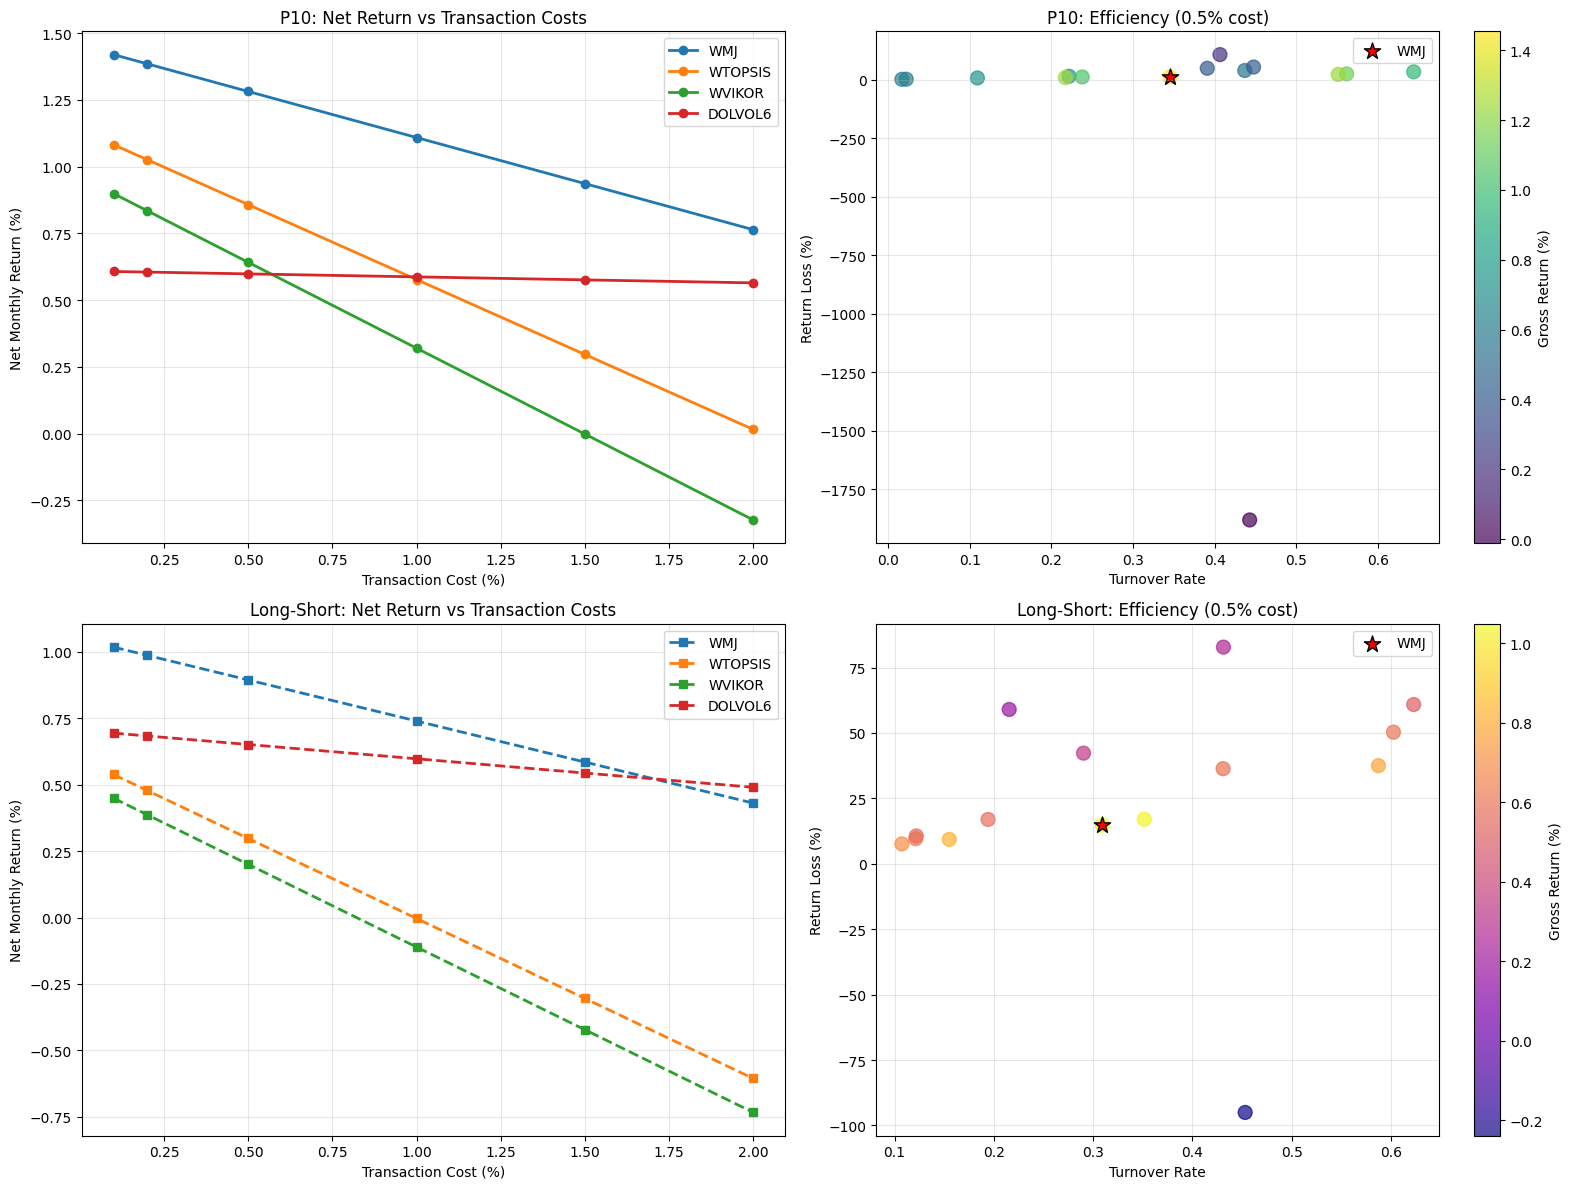


📋 SUMMARY TABLE - P10 Net Returns by Transaction Cost:
            Cost_0.1%  Cost_0.5%  Cost_1.0%
Method                                     
WMJ            0.0142     0.0128     0.0111
ILL6           0.0122     0.0114     0.0103
WPROMETHEE     0.0118     0.0096     0.0068
BM             0.0102     0.0093     0.0081
WTOPSIS        0.0108     0.0086     0.0058
GP             0.0075     0.0070     0.0065
BETA           0.0075     0.0066     0.0055
WVIKOR         0.0090     0.0064     0.0032
SIZE           0.0062     0.0062     0.0061
DOLVOL6        0.0061     0.0060     0.0059
CUMRET         0.0052     0.0034     0.0012
VOLATILITY     0.0036     0.0021     0.0001
ACC            0.0037     0.0019    -0.0003
AG             0.0015    -0.0001    -0.0022
NS            -0.0006    -0.0023    -0.0045

📋 SUMMARY TABLE - LONG-SHORT Net Returns by Transaction Cost:
            Cost_0.1%  Cost_0.5%  Cost_1.0%
Method                                     
WMJ            0.0102     0.0089     0.0074
N

In [14]:
def comprehensive_transaction_cost_analysis_extended():
    """
    Analisi completa dei costi di transazione per P10 e Long-Short
    """
    
    # 1. Raccogli turnover e rendimenti per P10 VW
    turnover_data_p10 = {}
    gross_returns_p10 = {}
    
    for method in weighted_portfolios.keys():
        if method in portfolios_stock_reallocation:
            df_turn = portfolios_stock_reallocation[method]['VW_turnover']
            turnover_p10 = df_turn[df_turn['portfolio'] == 10.0]['VW_turnover'].values[0]
            turnover_data_p10[method] = turnover_p10
            gross_returns_p10[method] = weighted_portfolios[method]['port10'].mean()
    
    # 2. Raccogli turnover e rendimenti per Long-Short VW
    # Per LS assumiamo che il turnover sia la media tra P1 e P10 (o usa metrica specifica se disponibile)
    turnover_data_ls = {}
    gross_returns_ls = {}
    
    for method in weighted_portfolios.keys():
        if method in portfolios_stock_reallocation:
            df_turn = portfolios_stock_reallocation[method]['VW_turnover']
            # Turnover LS = media ponderata tra P1 e P10 (o puoi usare metrica diversa)
            turnover_p1 = df_turn[df_turn['portfolio'] == 1.0]['VW_turnover'].values[0]
            turnover_p10 = df_turn[df_turn['portfolio'] == 10.0]['VW_turnover'].values[0]
            turnover_data_ls[method] = (turnover_p1 + turnover_p10) / 2  # Media semplice
            gross_returns_ls[method] = weighted_portfolios[method]['long_short'].mean()
    
    # 3. Range di costi di transazione realistici
    transaction_costs = [0.001, 0.002, 0.005, 0.01, 0.015, 0.02]  # 0.1% - 2%
    
    # 4. Calcola rendimenti netti per P10
    results_p10 = []
    for cost in transaction_costs:
        for method in turnover_data_p10.keys():
            gross_ret = gross_returns_p10[method]
            turnover = turnover_data_p10[method]
            
            cost_impact = turnover * cost
            net_return = gross_ret - cost_impact
            
            gross_series = weighted_portfolios[method]['port10']
            net_series = gross_series - cost_impact
            net_sharpe = calculate_sharpe_ratio(net_series)
            
            results_p10.append({
                'Strategy': 'P10',
                'Method': method.upper(),
                'Transaction_Cost': cost,
                'Turnover': turnover,
                'Gross_Return': gross_ret,
                'Cost_Impact': cost_impact,
                'Net_Return': net_return,
                'Net_Sharpe': net_sharpe,
                'Return_Loss_pct': (cost_impact / gross_ret) * 100 if gross_ret != 0 else 0
            })
    
    # 5. Calcola rendimenti netti per Long-Short
    results_ls = []
    for cost in transaction_costs:
        for method in turnover_data_ls.keys():
            gross_ret = gross_returns_ls[method]
            turnover = turnover_data_ls[method]
            
            cost_impact = turnover * cost
            net_return = gross_ret - cost_impact
            
            gross_series = weighted_portfolios[method]['long_short']
            net_series = gross_series - cost_impact
            net_sharpe = calculate_sharpe_ratio(net_series)
            
            results_ls.append({
                'Strategy': 'Long-Short',
                'Method': method.upper(),
                'Transaction_Cost': cost,
                'Turnover': turnover,
                'Gross_Return': gross_ret,
                'Cost_Impact': cost_impact,
                'Net_Return': net_return,
                'Net_Sharpe': net_sharpe,
                'Return_Loss_pct': (cost_impact / gross_ret) * 100 if gross_ret != 0 else 0
            })
    
    # 6. Combina i risultati
    all_results = results_p10 + results_ls
    return pd.DataFrame(all_results)

# Esegui analisi estesa
cost_analysis_extended = comprehensive_transaction_cost_analysis_extended()

# 7. Ranking separato per P10 e Long-Short
def print_strategy_rankings(df, strategy_name, costs_to_show=[0.001, 0.005, 0.01, 0.02]):
    print(f"\n🏆 RANKING {strategy_name.upper()} - RENDIMENTO NETTO:")
    print("=" * 80)
    
    strategy_data = df[df['Strategy'] == strategy_name]
    
    for cost in costs_to_show:
        subset = strategy_data[strategy_data['Transaction_Cost'] == cost].copy()
        subset = subset.sort_values('Net_Return', ascending=False)
        
        print(f"\n📊 Costo transazione: {cost*100:.1f}%")
        print(f"{'Rank':<4} {'Method':<12} {'Net Return':<12} {'Turnover':<10} {'Loss %':<8}")
        print("-" * 50)
        
        for i, (_, row) in enumerate(subset.head(5).iterrows(), 1):
            print(f"{i:<4} {row['Method']:<12} {row['Net_Return']:.4f}      {row['Turnover']:.4f}    {row['Return_Loss_pct']:.2f}%")
        
        # Posizione di WMJ
        wmj_subset = subset[subset['Method'] == 'WMJ']
        if not wmj_subset.empty:
            wmj_pos = subset.reset_index().query("Method == 'WMJ'").index[0] + 1
            print(f"🎯 WMJ Position: #{wmj_pos}")

# Stampa ranking per entrambe le strategie
print_strategy_rankings(cost_analysis_extended, 'P10')
print_strategy_rankings(cost_analysis_extended, 'Long-Short')

# 8. Analisi break-even comparativa
def break_even_analysis(df, strategy_name):
    print(f"\n\n💰 BREAK-EVEN ANALYSIS - {strategy_name.upper()}:")
    print("=" * 50)
    
    strategy_data = df[df['Strategy'] == strategy_name]
    wmj_data = strategy_data[strategy_data['Method'] == 'WMJ']
    
    if wmj_data.empty:
        print(f"⚠️ WMJ non trovato per {strategy_name}")
        return
    
    wmj_gross = wmj_data['Gross_Return'].iloc[0]
    wmj_turnover = wmj_data['Turnover'].iloc[0]
    
    print(f"WMJ Turnover: {wmj_turnover:.4f}")
    print(f"WMJ Gross Return: {wmj_gross:.4f}")
    
    competitors = ['WTOPSIS', 'WVIKOR', 'WPROMETHEE', 'DOLVOL6', 'GP', 'ILL6']
    unique_methods = strategy_data['Method'].unique()
    
    for comp in competitors:
        if comp in unique_methods:
            comp_data = strategy_data[strategy_data['Method'] == comp]
            comp_gross = comp_data['Gross_Return'].iloc[0]
            comp_turnover = comp_data['Turnover'].iloc[0]
            
            if abs(comp_turnover - wmj_turnover) > 1e-6:
                breakeven_cost = (comp_gross - wmj_gross) / (comp_turnover - wmj_turnover)
                if breakeven_cost > 0:
                    print(f"vs {comp}: Break-even cost = {breakeven_cost*100:.2f}%")
                else:
                    print(f"vs {comp}: WMJ dominante (sempre superiore)")

# Esegui break-even per entrambe
break_even_analysis(cost_analysis_extended, 'P10')
break_even_analysis(cost_analysis_extended, 'Long-Short')

# 9. Grafici comparativi
import matplotlib.pyplot as plt
import seaborn as sns

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: P10 - Net Return vs Transaction Cost
p10_data = cost_analysis_extended[cost_analysis_extended['Strategy'] == 'P10']
methods_to_plot = ['WMJ', 'WTOPSIS', 'WVIKOR', 'DOLVOL6']
p10_subset = p10_data[p10_data['Method'].isin(methods_to_plot)]

for method in methods_to_plot:
    method_data = p10_subset[p10_subset['Method'] == method]
    if not method_data.empty:
        ax1.plot(method_data['Transaction_Cost']*100, method_data['Net_Return']*100, 
                marker='o', label=method, linewidth=2)

ax1.set_xlabel('Transaction Cost (%)')
ax1.set_ylabel('Net Monthly Return (%)')
ax1.set_title('P10: Net Return vs Transaction Costs')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: P10 - Return Loss vs Turnover
p10_cost_05 = p10_data[p10_data['Transaction_Cost'] == 0.005]
scatter1 = ax2.scatter(p10_cost_05['Turnover'], p10_cost_05['Return_Loss_pct'], 
                      c=p10_cost_05['Gross_Return']*100, cmap='viridis', s=100, alpha=0.7)

wmj_p10 = p10_cost_05[p10_cost_05['Method'] == 'WMJ']
if not wmj_p10.empty:
    ax2.scatter(wmj_p10['Turnover'], wmj_p10['Return_Loss_pct'], 
               color='red', s=150, marker='*', label='WMJ', edgecolor='black')

ax2.set_xlabel('Turnover Rate')
ax2.set_ylabel('Return Loss (%)')
ax2.set_title('P10: Efficiency (0.5% cost)')
plt.colorbar(scatter1, ax=ax2, label='Gross Return (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Long-Short - Net Return vs Transaction Cost
ls_data = cost_analysis_extended[cost_analysis_extended['Strategy'] == 'Long-Short']
ls_subset = ls_data[ls_data['Method'].isin(methods_to_plot)]

for method in methods_to_plot:
    method_data = ls_subset[ls_subset['Method'] == method]
    if not method_data.empty:
        ax3.plot(method_data['Transaction_Cost']*100, method_data['Net_Return']*100, 
                marker='s', label=method, linewidth=2, linestyle='--')

ax3.set_xlabel('Transaction Cost (%)')
ax3.set_ylabel('Net Monthly Return (%)')
ax3.set_title('Long-Short: Net Return vs Transaction Costs')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Long-Short - Return Loss vs Turnover
ls_cost_05 = ls_data[ls_data['Transaction_Cost'] == 0.005]
scatter2 = ax4.scatter(ls_cost_05['Turnover'], ls_cost_05['Return_Loss_pct'], 
                      c=ls_cost_05['Gross_Return']*100, cmap='plasma', s=100, alpha=0.7)

wmj_ls = ls_cost_05[ls_cost_05['Method'] == 'WMJ']
if not wmj_ls.empty:
    ax4.scatter(wmj_ls['Turnover'], wmj_ls['Return_Loss_pct'], 
               color='red', s=150, marker='*', label='WMJ', edgecolor='black')

ax4.set_xlabel('Turnover Rate')
ax4.set_ylabel('Return Loss (%)')
ax4.set_title('Long-Short: Efficiency (0.5% cost)')
plt.colorbar(scatter2, ax=ax4, label='Gross Return (%)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 10. Tabelle finali comparative
def create_summary_table(df, strategy_name):
    strategy_data = df[df['Strategy'] == strategy_name]
    summary_costs = strategy_data[strategy_data['Transaction_Cost'].isin([0.001, 0.005, 0.01])]
    
    pivot_table = summary_costs.pivot(index='Method', columns='Transaction_Cost', values='Net_Return')
    pivot_table.columns = [f'Cost_{c*100:.1f}%' for c in pivot_table.columns]
    pivot_table = pivot_table.sort_values('Cost_0.5%', ascending=False)
    
    print(f"\n📋 SUMMARY TABLE - {strategy_name.upper()} Net Returns by Transaction Cost:")
    print(pivot_table.round(4))
    
    return pivot_table

# Crea tabelle per entrambe le strategie
summary_p10 = create_summary_table(cost_analysis_extended, 'P10')
summary_ls = create_summary_table(cost_analysis_extended, 'Long-Short')

# 11. Confronto diretto P10 vs Long-Short per WMJ
print("\n🔍 WMJ: P10 vs Long-Short Performance")
print("=" * 50)

wmj_comparison = cost_analysis_extended[cost_analysis_extended['Method'] == 'WMJ']
for cost in [0.001, 0.005, 0.01, 0.02]:
    cost_data = wmj_comparison[wmj_comparison['Transaction_Cost'] == cost]
    p10_row = cost_data[cost_data['Strategy'] == 'P10']
    ls_row = cost_data[cost_data['Strategy'] == 'Long-Short']
    
    if not p10_row.empty and not ls_row.empty:
        p10_net = p10_row['Net_Return'].iloc[0]
        ls_net = ls_row['Net_Return'].iloc[0]
        p10_turnover = p10_row['Turnover'].iloc[0]
        ls_turnover = ls_row['Turnover'].iloc[0]
        
        print(f"\nCosto {cost*100:.1f}%:")
        print(f"  P10:        Net Return = {p10_net:.4f}, Turnover = {p10_turnover:.4f}")
        print(f"  Long-Short: Net Return = {ls_net:.4f}, Turnover = {ls_turnover:.4f}")
        print(f"  Differenza: {ls_net - p10_net:.4f} {'(LS > P10)' if ls_net > p10_net else '(P10 > LS)'}")


DataFrame normalizzato:
             Rendimento medio  Volatilità  Sharpe Ratio  Max Drawdown
Metodo                                                              
dolvol6             0.000000    1.000000      0.000000      1.000000
wmj                 1.000000    0.000000      1.000000      0.629000
wtopsis             0.626229    0.262188      0.633344      0.000000
wpromethee          0.736619    0.265808      0.786924      0.178012


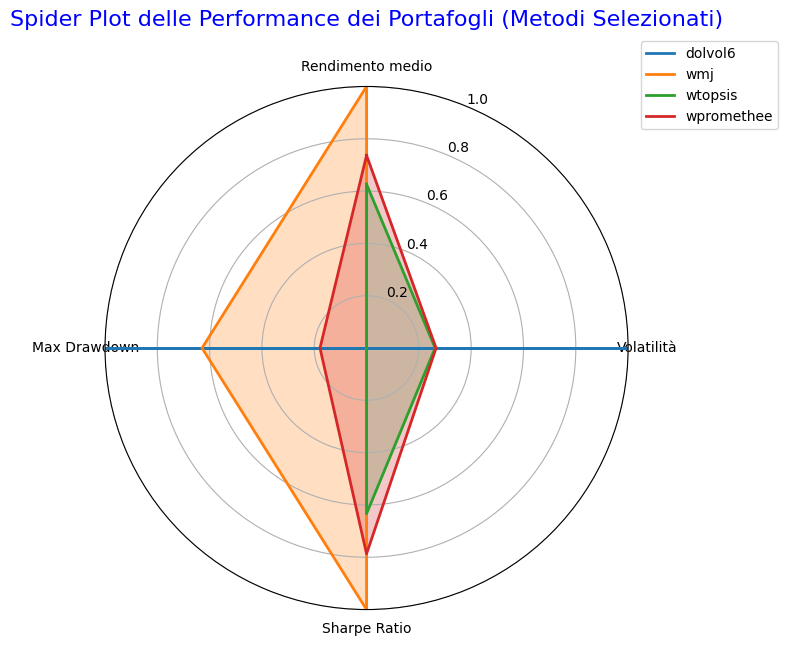

In [15]:
# Parte 12- spider plot che non e' neanche sto gran vedere

import numpy as np
import matplotlib.pyplot as plt

def plot_spider(df_stats, metodi_spider_plot):
    df_filtered_stats = df_stats[df_stats['Metodo'].isin(metodi_spider_plot)].set_index('Metodo')

    categories = ['Rendimento medio', 'Volatilità', 'Sharpe Ratio', 'Max Drawdown']

    normalized_df = pd.DataFrame(index=df_filtered_stats.index, columns=categories)

    for col in categories:
        if col in ['Rendimento medio', 'Sharpe Ratio']:
            min_val = df_filtered_stats[col].min()
            max_val = df_filtered_stats[col].max()
            normalized_df[col] = (df_filtered_stats[col] - min_val) / (max_val - min_val) if (max_val - min_val) != 0 else 0
        elif col in ['Volatilità', 'Max Drawdown']:
            min_val = df_filtered_stats[col].min()
            max_val = df_filtered_stats[col].max()
            if (max_val - min_val) != 0:
                normalized_df[col] = 1 - (df_filtered_stats[col] - min_val) / (max_val - min_val)
            else:
                normalized_df[col] = 0

    normalized_df = normalized_df.fillna(0).clip(0, 1)
    print("\nDataFrame normalizzato:\n", normalized_df)

    labels = np.array(categories)
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    for i, row in normalized_df.iterrows():
        values = row.tolist()
        values += values[:1]

        ax.plot(angles, values, linewidth=2, linestyle='solid', label=i)
        ax.fill(angles, values, alpha=0.25)

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)

    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"])
    ax.set_ylim(0, 1)

    plt.title('Spider Plot delle Performance dei Portafogli (Metodi Selezionati)', size=16, color='blue', y=1.1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()

metodi_spider_plot = ['dolvol6', 'wmj', 'wtopsis', 'vikor', 'wpromethee']
plot_spider(stats_vw, metodi_spider_plot )

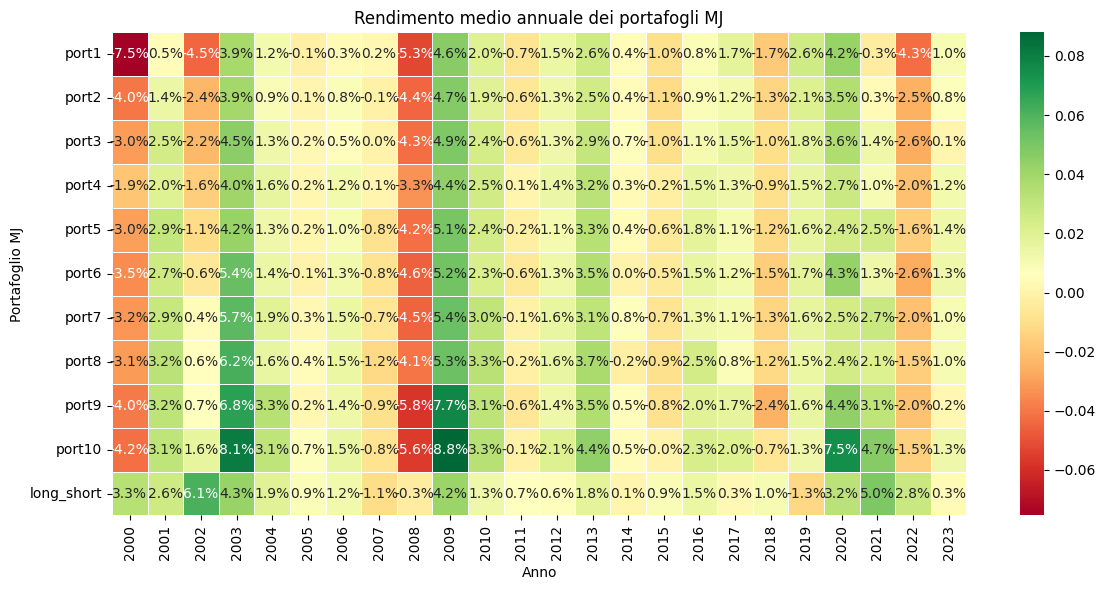

In [16]:
import seaborn as sns

df_mj = portfolios['mj'].copy()
df_mj.index = pd.to_datetime(df_mj.index)

mj_annual_returns = df_mj.resample('Y').mean()
mj_annual_returns.index = mj_annual_returns.index.year

# 4. Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(mj_annual_returns.T, cmap="RdYlGn", annot=True, fmt=".1%", linewidths=.5)
plt.title("Rendimento medio annuale dei portafogli MJ")
plt.xlabel("Anno")
plt.ylabel("Portafoglio MJ")
plt.tight_layout()
plt.show()


In [17]:
def calculate_rolling_sortino_ratio(excess_returns, window=36, target_return=0, annualization_factor=12):
   """
   Calculate rolling Sortino ratio with specified window length.
  
   Parameters:
   excess_returns (pd.Series): Monthly excess returns
   window (int): Rolling window size in months, defaults to 36
   target_return (float): Minimum acceptable return, typically 0
   annualization_factor (int): 12 for monthly data
  
   Returns:
   pd.Series: Rolling Sortino ratio
   """
   # Function to calculate Sortino ratio for a single window
   def sortino_for_window(window_returns):
       # Isolate downside returns
       downside_returns = window_returns.copy()
       downside_returns[downside_returns > target_return] = 0
      
       # Calculate downside deviation
       downside_deviation = np.sqrt(np.mean(downside_returns**2)) * np.sqrt(annualization_factor)
      
       # Calculate annualized return
       annualized_return = window_returns.mean() * annualization_factor
      
       # Return Sortino ratio (handle division by zero)
       if downside_deviation == 0:
           return np.nan
       return annualized_return / downside_deviation
  
   # Apply rolling calculation
   rolling_sortino = excess_returns.rolling(window=window).apply(sortino_for_window, raw=False)
  
   return rolling_sortino

def calculate_rolling_maximum_drawdown(excess_returns, window=36):
   """
   Calculate rolling maximum drawdown with specified window length.
  
   Parameters:
   excess_returns (pd.Series): Monthly excess returns
   window (int): Rolling window size in months, defaults to 36
  
   Returns:
   pd.Series: Rolling maximum drawdown (as positive values)
   """
   # Function to calculate max drawdown for a single window
   def max_drawdown_for_window(window_returns):
       # Convert returns to cumulative returns
       cumulative_returns = (1 + window_returns).cumprod()
      
       # Calculate running maximum
       running_max = cumulative_returns.cummax()
      
       # Calculate drawdown
       drawdown = (cumulative_returns / running_max) - 1
      
       # Find maximum drawdown
       max_drawdown = drawdown.min()
      
       # Return as positive value
       return abs(max_drawdown)
  
   # Apply rolling calculation
   rolling_mdd = excess_returns.rolling(window=window).apply(max_drawdown_for_window, raw=False)
  
   return rolling_mdd

def compute_portfolio_performance(df, window_size=36):
   """
   Compute rolling performance metrics for a portfolio
  
   Parameters:
   -----------
   df: DataFrame containing columns:
   port_excess :  Time series of portfolio excess returns
   mkt_excess :  Time series of market excess returns
   window_size : int
       Size of the rolling window in months (default: 36 for 3 years)
      
   Returns:
   --------
   pandas.DataFrame
       DataFrame with rolling performance metrics
   """
   # Ensure all inputs are aligned and have the same index
   data=df.copy()


   # Calculate active returns (portfolio excess returns minus benchmark excess returns)
   data['port_minus_mkt'] = data['port_excess'] - data['mkt_excess']
  
   # Calculate rolling performance metrics
   performance = pd.DataFrame(index=data.index)
  
   # Mean return (annualized)
   performance['Av_ret'] = data['port_excess'].rolling(window=window_size).mean() * 12
  
   # Volatility (annualized)
   performance['Vol_ret'] = data['port_excess'].rolling(window=window_size).std() * np.sqrt(12)
  
   # Sharpe ratio (annualized)
   performance['Sharpe_ratio'] = (
       data['port_excess'].rolling(window=window_size).mean() /
       data['port_excess'].rolling(window=window_size).std()
   ) * np.sqrt(12)
  
   # For beta calculation, need rolling covariance and variance
   def rolling_beta(df, window):
       cov = df['port_excess'].rolling(window=window).cov(df['mkt_excess'])
       var = df['mkt_excess'].rolling(window=window).var()
       return cov / var
  
   performance['beta'] = rolling_beta(data, window_size)
  
   # Treynor ratio (annualized)
   raw_treynor = (
       data['port_excess'].rolling(window=window_size).mean() /
       (performance['beta'])
   ) * 12


   lower_bound = np.percentile(raw_treynor.dropna(), 5)
   upper_bound = np.percentile(raw_treynor.dropna(), 95)
  
   performance['Treynor_ratio'] = raw_treynor.clip(lower=lower_bound, upper=upper_bound)
  
   # Information ratio (annualized) - FIXED
   # Uses port_minus_mkt (active returns) to calculate the Information Ratio
   active_return_mean = data['port_minus_mkt'].rolling(window=window_size).mean()
   tracking_error = data['port_minus_mkt'].rolling(window=window_size).std()
   performance['Information_ratio'] = (active_return_mean / tracking_error) * np.sqrt(12)
  
   # Jensen's alpha (annualized)
   performance['alpha'] = (
       data['port_excess'].rolling(window=window_size).mean() -
       performance['beta'] * data['mkt_excess'].rolling(window=window_size).mean()
   ) * 12
  
   # Drop NaN values from the initial window period
   #performance = performance.dropna()
   performance['Sortino_ratio'] = calculate_rolling_sortino_ratio(data['port_excess'], window=window_size)
   performance['Max_Drawdown'] = calculate_rolling_maximum_drawdown(data['port_excess'], window=window_size)
  
   return performance

def identify_market_regimes(returns, window=12):
   """
   Identify bullish and bearish market regimes based on cumulative returns
   over the specified window.
  
   Definition:
   - Bull market: When cumulative returns over the past window months > 0
   - Bear market: When cumulative returns over the past window months <= 0
  
   Parameters:
   -----------
   returns : pandas.Series or numpy.ndarray
       Time series of monthly market returns
   window : int, default 24
       Number of months to look back for calculating cumulative returns
      
   Returns:
   --------
   pandas.DataFrame
       DataFrame with columns:
       - 'returns': original returns
       - 'cum_returns': cumulative returns over the specified window
       - 'regime': market regime (1 for bullish, -1 for bearish)
   """
   import numpy as np
   import pandas as pd
  
   # Convert to pandas Series if numpy array
   if isinstance(returns, np.ndarray):
       returns = pd.Series(returns)
  
   # Calculate rolling cumulative returns over the specified window
   rolling_cum_returns = np.zeros_like(returns)
  
   for i in range(len(returns)):
       # For each point, calculate cumulative returns over the past 'window' months
       start_idx = max(0, i - window + 1)
       if i >= window - 1:  # We have enough data for a full window
           rolling_cum_returns[i] = (1 + returns.iloc[start_idx:i+1]).prod() - 1
       else:  # Not enough data for a full window, use all available data
           rolling_cum_returns[i] = (1 + returns.iloc[0:i+1]).prod() - 1
  
   # Determine market regime
   # Bull market: cumulative returns > 0
   # Bear market: cumulative returns <= 0
   regime = np.ones_like(returns)  # Initialize as bull market
   regime[rolling_cum_returns <= 0.0] = -1  # Bear market
  
   # Create output DataFrame
   result = pd.DataFrame({
       'returns': returns,
       'cum_returns': rolling_cum_returns,
       'regime': regime
   })
  
   return result

def compare_bull_bear_market_indicators(data, window_size=36,port='long_short',regime_window=12):
   """
   Compare multiple investment strategies using Treynor ratio and other metrics
  
   Parameters:
   -----------
   data: Dictionary with portfolio and market excess returns ('mkt_excess', 'port_excess')
   window_size : window for performance
   regime window: window for market regime
   port: type of portfolio
  
   Returns:
   --------
   dict
       Dictionary containing performance metrics for each strategy and comparison statistics
   """
  
   perf = compute_portfolio_performance(
       data,
       window_size=window_size
   )
  
   # Create comparison dataframe for key metrics
   perf_names=perf.columns


   # 0. Performance during different market conditions
   # Define bull/bear markets (simplistic approach using rolling returns)
   regime_res=identify_market_regimes(data['mkt_excess'],
                                      window=regime_window)
   bull_market=regime_res['regime']==1
   bear_market=regime_res['regime']==-1


  
  
   comparison = {}
   for PI in perf_names:
       comparison[PI]={}
       # 1. Average Treynor ratio over the entire period
       comparison[PI][f'avg']  =  perf[PI].mean()
       comparison[PI][f'bull'] = perf.loc[bull_market, PI].mean()
       comparison[PI][f'bear'] = perf.loc[bear_market, PI].mean()
  
  
  
  
   return {
       'detailed_metrics': perf,
       'comparison': comparison
   }


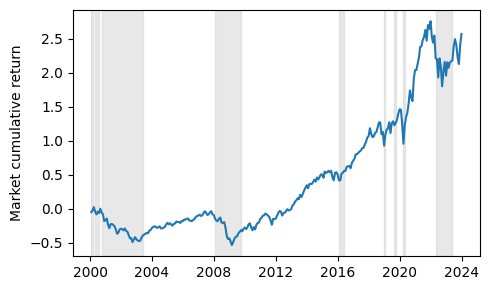

In [ ]:
## DEFINIAMO QUALCHE PARAMETRO ED IL RENDIMENTO DI MERCATO (=bull/bear)
## Intervallo ribassista (se array >=2) --> rettangolo grigio, basato sul rendimento cumulato

mkt_rf_df= df_norm[['date','Mkt_RF']].drop_duplicates()         # Il nuovo df contiene date e rendimento in eccesso del mkt
mkt_rf_df = mkt_rf_df.rename(columns={'date':'medate'})
mkt_rf_df = mkt_rf_df.reset_index(drop=True)
mkt_rf_df=mkt_rf_df.sort_values(by='medate')

port='long_short'
window=36                                           ## Per calcolare le metriche, standard
regime_window=12                                    ## Per identificare BB, standard

########################################################################################
# Plottare la serie temporale del rendimento cumulato del mercato (Mkt_RF), 
# Evidenziando i periodi di bear market (regimi ribassisti)
########################################################################################

fig, ax = plt.subplots(figsize=(5, 3))

#### PLOT MARKET REGIMES IN TIME
df_mkt=mkt_rf_df.copy()
regime_window=12

## Questa funziona che calcolo cumulato su 12 mesi e guardo se > 0, aggiungo colonne cumulato e bb al df
df_mkt[['cum_returns','regime']]=identify_market_regimes(df_mkt['Mkt_RF'],regime_window)[['cum_returns','regime']] # Funzione per identificare i regimi di mercato


# Find regions with at least two consecutive regime = -1
consecutive_regions = []
start_idx = None
for i in range(len(df_mkt)):
   # Start of a new potential region
   if df_mkt['regime'].iloc[i] == -1.0 and start_idx is None:
       start_idx = i
  
   # End of a potential region
   elif df_mkt['regime'].iloc[i] != -1.0 and start_idx is not None:
       # Check if we have at least 2 consecutive -1 values
       if i - start_idx >= 2:
           consecutive_regions.append((start_idx, i-1))
       start_idx = None
  
   # Handle the last region if it extends to the end of the data
   if i == len(df_mkt) - 1 and start_idx is not None:
       if i - start_idx >= 1:  # At least 2 points total
           consecutive_regions.append((start_idx, i))


# Add background shadowing for the consecutive regions
for start, end in consecutive_regions:
   start_date = df_mkt['medate'].iloc[start]
   end_date = df_mkt['medate'].iloc[end]
   ax.axvspan(start_date, end_date, color='lightgrey', alpha=0.5, label='bear market')


ax.plot(df_mkt['medate'], ((1+df_mkt['Mkt_RF']).cumprod()-1),label='market cumulative')

#plt.title('Rolling Sharpe Ratio: EW vs VW')
ax.set_ylabel('Market cumulative return') #r'Jensen $\alpha$' , 'Information Ratio'
plt.tight_layout()
plt.savefig(f'Market_regimes.pdf')
plt.show()

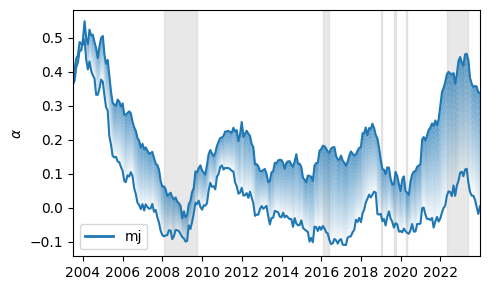

Mostro le caratteristiche del metodo mj


,Av_ret,Vol_ret,Sharpe_ratio,beta,Treynor_ratio,Information_ratio,alpha,Sortino_ratio,Max_Drawdown
avg,0.048578,0.125779,0.242310,0.133003,0.001614,-0.391026,0.030651,0.896093,0.194106
bull,0.066381,0.127185,0.389126,0.154357,0.044260,-0.385538,0.043276,1.207275,0.183058
bear,-0.023362,0.120094,-0.350947,0.046715,-0.170711,-0.413203,-0.020362,-0.361340,0.238749


In [48]:
######################
# COMPUTE TIME VARYING PERFORMANCE (=metrica rolling)
######################

## ------>> MODIIFCARE QUA SE VUOI VEDERE ALTRI METODI

metodo_rolling = 'mj'
metodi_speciali = ['mj', 'topsis', 'vikor', 'promethee']

type_port='long_short'
#EW portfolio of interest
EW_portfolio=portfolios[metodo_rolling][type_port]
EW_data=df_mkt.merge(EW_portfolio.reset_index(),on='medate',how='outer').set_index('medate')[['Mkt_RF',type_port]]
EW_data=EW_data.rename(columns={'Mkt_RF':'mkt_excess',type_port:'port_excess'})

#VW portfolio of interest  ###### MODIFY HERE!!!!!!!!!!!!!
if metodo_rolling in metodi_speciali:
    VW_portfolio=weighted_portfolios['w' + metodo_rolling][[type_port]]-0.005   
else:
    VW_portfolio=weighted_portfolios[metodo_rolling][[type_port]]-0.005
VW_data=df_mkt.merge(VW_portfolio.reset_index(),on='medate',how='outer').set_index('medate')[['Mkt_RF',type_port]]
VW_data=VW_data.rename(columns={'Mkt_RF':'mkt_excess',type_port:'port_excess'})

## COMPUTE PERFORMANCE
perfs=compute_portfolio_performance(EW_data, window_size=36)        ## Qua calcolo le performance del portafoglio EW
wperfs=compute_portfolio_performance(VW_data, window_size=36)       ## Qua calcolo le performance del portafoglio VW, su 36 mesi


######################
# PLOT TIME VARYING PERFORMANCE (visualizzo sia ew che vw)
######################
## --> le differenze le vedo con il gradiente

import matplotlib.dates as mdates

performance='alpha' #['Av_ret', 'Vol_ret', 'Sharpe_ratio', 'beta', 'Treynor_ratio', 'Information_ratio', 'alpha', 'Sortino_ratio', 'Max_Drawdown']

names={'Av_ret':'Excess return',
      'Vol_ret': 'Excess Volatility',
      'Sharpe_ratio': 'Sharpe Ratio',
      'beta': r'$\beta$',
      'Treynor_ratio': 'Treynor Ratio',
      'Information_ratio': 'Information Ratio',
      'alpha': r'$\alpha$',
      'Sortino_ratio': 'Sortino Ratio',
      'Max_Drawdown': 'Maximum Drawdown'}

############################################################################################################### INIZIO BLOCCO X GRAFICO BB #####################################
# Plot shaded area between the two series for each method with gradient (no borders)
num_layers = 20  # Number of layers in the gradient

fig, ax = plt.subplots(figsize=(5, 3))

# Find regions with at least two consecutive regime = -1
consecutive_regions = []
start_idx = None
for i in range(len(df_mkt)):
   # Start of a new potential region
   if df_mkt['regime'].iloc[i] == -1.0 and start_idx is None:
       start_idx = i
  
   # End of a potential region
   elif df_mkt['regime'].iloc[i] != -1.0 and start_idx is not None:
       # Check if we have at least 2 consecutive -1 values
       if i - start_idx >= 2:
           consecutive_regions.append((start_idx, i-1))
       start_idx = None
  
   # Handle the last region if it extends to the end of the data
   if i == len(df_mkt) - 1 and start_idx is not None:
       if i - start_idx >= 1:  # At least 2 points total
           consecutive_regions.append((start_idx, i))


# Add background shadowing for the consecutive regions
for start, end in consecutive_regions:
   start_date = df_mkt['medate'].iloc[start]
   end_date = df_mkt['medate'].iloc[end]
   ax.axvspan(start_date, end_date, color='lightgrey', alpha=0.5)

# Plot the lines
ax.plot(perfs.index, perfs[performance], color='C0')  # solid line for lower edge
ax.plot(perfs.index, wperfs[performance], color='C0', linewidth=1.5)  # solid line for upper edge
############################################################################################################### FINE BLOCCO X GRAFICO BB #####################################

initial_alpha=0.7

# Create gradient
for i in range(num_layers):
   alpha = initial_alpha - (initial_alpha * i / num_layers)  # Decreasing alpha from 0.5 to 0
   interp = i / num_layers
   y_bottom = perfs[performance] + (wperfs[performance] - perfs[performance]) * interp
   y_top = perfs[performance] + (wperfs[performance] - perfs[performance]) * (interp + 1/num_layers)
   ax.fill_between(perfs.index, y_bottom, y_top, color='C0', alpha=alpha, linewidth=0)

# Add legend entries for the methods
ax.plot([], [], color='C0', label='mj', linewidth=2)

# Set x-axis limits to exactly match the data range
ax.set_xlim(min(perfs.loc[perfs['Av_ret'].notna()].index),max(perfs.loc[perfs['Av_ret'].notna()].index))


# Add labels and title
#plt.title('Rolling Sharpe Ratio: EW vs VW')
ax.set_ylabel(names[performance]) #r'Jensen $\alpha$' , 'Information Ratio'
plt.legend()
plt.tight_layout()
#plt.savefig(f'fixed_results/Rolling{performance}_{port}_{window}.pdf')
plt.show()

##################################################################
# COMPUTE AVG TIME VARYING INDICATORS
##################################################################

## --> ogni finestra di 3 anni ha prodotto un rendimento annuo del 18.47%
## --> io sopra faccio media su (esempio) 72 mesi in unico blocco, qua fa 1-36, 2-37,...,37-72, e poi fa la media delle medie.

# Compute perfromance in different market regimes
print(f"Mostro le caratteristiche del metodo {metodo_rolling}")
EW_TV_performances = compare_bull_bear_market_indicators(EW_data, window_size=window,port=port)['comparison']
VW_TV_performances = compare_bull_bear_market_indicators(VW_data, window_size=window,port=port)['comparison']

#pd.DataFrame(EW_TV_performances)
pd.DataFrame(VW_TV_performances)

In [49]:
# --- Parametri/Setup
metodi_rolling_EW = ['mj', 'topsis', 'vikor', 'promethee', 'gp', 'ill6', 'dolvol6']
metodi_speciali = ['mj', 'topsis', 'vikor', 'promethee']
type_port = 'long_short'
window = 36
port = type_port

# Se vuoi sottrarre una fee mensile, definiscila qui (es. 0.00035 ~ 0.42% annuo)
fee_mensile = 0.005

# Colleziono i risultati per riepilogo finale
righe = []

for metodo in metodi_rolling_EW:
    # --- EW
    EW_portfolio = portfolios[metodo][type_port]
    EW_data = (
        df_mkt.merge(EW_portfolio.reset_index(), on='medate', how='outer')
             .set_index('medate')[['Mkt_RF', type_port]]
             .rename(columns={'Mkt_RF': 'mkt_excess', type_port: 'port_excess'})
    )

    # --- VW: se metodo ha versione weighted -> usa 'w' + metodo
    vw_key = f"w{metodo}" if metodo in metodi_speciali else metodo
    VW_portfolio = weighted_portfolios[vw_key][[type_port]] - fee_mensile

    VW_data = (
        df_mkt.merge(VW_portfolio.reset_index(), on='medate', how='outer')
             .set_index('medate')[['Mkt_RF', type_port]]
             .rename(columns={'Mkt_RF': 'mkt_excess', type_port: 'port_excess'})
    )

    # --- (opzionale) performance rolling
    perfs  = compute_portfolio_performance(EW_data, window_size=window)
    wperfs = compute_portfolio_performance(VW_data, window_size=window)

    print('#' * 100)
    print(f"Mostro le caratteristiche del metodo {metodo}")
    print('#' * 100)

    EW_TV = compare_bull_bear_market_indicators(EW_data, window_size=window, port=port)['comparison']
    VW_TV = compare_bull_bear_market_indicators(VW_data, window_size=window, port=port)['comparison']

    # Visualizza le tabelle nel loop, se vuoi
    display(pd.DataFrame(EW_TV))
    display(pd.DataFrame(VW_TV))

    # Normalizzo in DataFrame con colonna 'Regime' se non c'è
    def _to_df(x):
        df = pd.DataFrame(x)
        if 'Regime' not in df.columns:
            df = df.rename_axis('Regime').reset_index()
        return df

    df_ew = _to_df(EW_TV).assign(Metodo=metodo, Peso='EW')
    df_vw = _to_df(VW_TV).assign(Metodo=metodo, Peso='VW')

    righe.extend([df_ew, df_vw])

# === RIEPILOGO COMPLESSIVO ===
df_all = pd.concat(righe, ignore_index=True)

# Tieni solo il regime 'avg' per la classifica richiesta
df_avg = df_all[df_all['Regime'].str.lower().eq('avg')].copy()

# Metrihe attese (nomi come nelle tue colonne)
metrics = [
    'Av_ret', 'Vol_ret', 'Sharpe_ratio', 'beta',
    'Treynor_ratio', 'Information_ratio', 'alpha',
    'Sortino_ratio', 'Max_Drawdown'
]

# Regole di selezione: min/max o criterio custom
minimize = {'Vol_ret'}  # queste le minimizziamo
maximize = {'Av_ret', 'Sharpe_ratio', 'Treynor_ratio', 'Information_ratio', 'alpha', 'Sortino_ratio', 'Max_Drawdown'}
# beta: scegliamo più vicino a un target (0 di default; usa 1.0 se vuoi beta ~ mercato)
beta_target = 0.0

def pick_best_for_metric(df, metric):
    if metric == 'beta':
        idx = (df[metric] - beta_target).abs().idxmin()
        return df.loc[idx]
    elif metric in minimize:
        idx = df[metric].idxmin()
        return df.loc[idx]
    elif metric in maximize:
        idx = df[metric].idxmax()
        return df.loc[idx]
    else:
        # fallback: massimizza
        idx = df[metric].idxmax()
        return df.loc[idx]

# Stampa i migliori per EW e VW separatamente
for peso in ['EW', 'VW']:
    sub = df_avg[df_avg['Peso'] == peso].reset_index(drop=True)
    if sub.empty:
        print(f"\n[ATTENZIONE] Nessun dato per Peso={peso}")
        continue

    print(f"\n=== Migliori per metrica (Regime=avg) — {peso} ===")
    for m in metrics:
        if m not in sub.columns:
            print(f"- {m}: colonna non presente")
            continue
        row = pick_best_for_metric(sub, m)
        metodo = row['Metodo']
        val = row[m]
        print(f"- {m}: {metodo} (val={val:.6f})")

# Se vuoi anche una tabella “wide” con i vincitori:
def winners_table(df, peso):
    sub = df[df['Peso'] == peso].reset_index(drop=True)
    out = {}
    for m in metrics:
        if m not in sub.columns:
            out[m] = 'N/A'
            continue
        row = pick_best_for_metric(sub, m)
        out[m] = row['Metodo']
    return pd.DataFrame(out, index=[peso])

tab_vincitori = pd.concat([winners_table(df_avg, 'EW'),
                           winners_table(df_avg, 'VW')])
print("\n=== Tabella vincitori (Regime=avg) ===")
display(tab_vincitori)


####################################################################################################
Mostro le caratteristiche del metodo mj
####################################################################################################


,Av_ret,Vol_ret,Sharpe_ratio,beta,Treynor_ratio,Information_ratio,alpha,Sortino_ratio,Max_Drawdown
avg,0.184725,0.133722,1.299281,-0.263950,-0.911316,0.336838,0.204099,3.873317,0.113987
bull,0.191516,0.133525,1.380104,-0.264195,-0.766884,0.318131,0.212802,4.162795,0.106238
bear,0.157284,0.134522,0.972689,-0.262961,-1.494942,0.412428,0.168933,2.703587,0.145300


,Av_ret,Vol_ret,Sharpe_ratio,beta,Treynor_ratio,Information_ratio,alpha,Sortino_ratio,Max_Drawdown
avg,0.048578,0.125779,0.242310,0.133003,0.001614,-0.391026,0.030651,0.896093,0.194106
bull,0.066381,0.127185,0.389126,0.154357,0.044260,-0.385538,0.043276,1.207275,0.183058
bear,-0.023362,0.120094,-0.350947,0.046715,-0.170711,-0.413203,-0.020362,-0.361340,0.238749


####################################################################################################
Mostro le caratteristiche del metodo topsis
####################################################################################################


,Av_ret,Vol_ret,Sharpe_ratio,beta,Treynor_ratio,Information_ratio,alpha,Sortino_ratio,Max_Drawdown
avg,0.166010,0.127141,1.209000,-0.348206,-0.814139,0.259123,0.195116,3.390135,0.109896
bull,0.166878,0.125800,1.267600,-0.363526,-0.788680,0.216746,0.199876,3.617971,0.100449
bear,0.162611,0.132397,0.979386,-0.288178,-0.913900,0.425171,0.176467,2.497388,0.146914


,Av_ret,Vol_ret,Sharpe_ratio,beta,Treynor_ratio,Information_ratio,alpha,Sortino_ratio,Max_Drawdown
avg,-0.009189,0.115288,-0.180564,0.107803,-0.478149,-0.724905,-0.021630,0.130008,0.237961
bull,0.005118,0.115030,-0.068965,0.119177,-0.447952,-0.742466,-0.011648,0.336768,0.216876
bear,-0.065251,0.116299,-0.617849,0.063234,-0.596474,-0.656096,-0.060746,-0.680154,0.320579


####################################################################################################
Mostro le caratteristiche del metodo vikor
####################################################################################################


,Av_ret,Vol_ret,Sharpe_ratio,beta,Treynor_ratio,Information_ratio,alpha,Sortino_ratio,Max_Drawdown
avg,0.113246,0.117947,0.928664,-0.361444,-0.311950,0.050987,0.140534,2.184068,0.128199
bull,0.115540,0.117080,0.974427,-0.386211,-0.286912,0.001173,0.145919,2.363739,0.123617
bear,0.104256,0.121344,0.749350,-0.264396,-0.410056,0.246176,0.119431,1.480054,0.146157


,Av_ret,Vol_ret,Sharpe_ratio,beta,Treynor_ratio,Information_ratio,alpha,Sortino_ratio,Max_Drawdown
avg,-0.023939,0.119751,-0.210342,0.235660,-0.127633,-0.806284,-0.047990,-0.071246,0.239119
bull,-0.008690,0.117359,-0.084693,0.256928,-0.145607,-0.824188,-0.039423,0.122325,0.216054
bear,-0.083687,0.129125,-0.702681,0.152326,-0.057207,-0.736133,-0.081557,-0.829732,0.329495


####################################################################################################
Mostro le caratteristiche del metodo promethee
####################################################################################################


,Av_ret,Vol_ret,Sharpe_ratio,beta,Treynor_ratio,Information_ratio,alpha,Sortino_ratio,Max_Drawdown
avg,0.169656,0.132101,1.194600,-0.356540,-0.854725,0.258484,0.196870,3.187575,0.125441
bull,0.173227,0.131978,1.248442,-0.376462,-0.817390,0.218900,0.204242,3.416391,0.117490
bear,0.155662,0.132586,0.983626,-0.278481,-1.001015,0.413589,0.167984,2.290988,0.156596


,Av_ret,Vol_ret,Sharpe_ratio,beta,Treynor_ratio,Information_ratio,alpha,Sortino_ratio,Max_Drawdown
avg,0.011230,0.119127,-0.026936,0.095056,-0.315467,-0.603527,-0.002408,0.430508,0.221429
bull,0.028308,0.118432,0.101467,0.104949,-0.269648,-0.609609,0.010117,0.696986,0.201768
bear,-0.055688,0.121851,-0.530067,0.056292,-0.495002,-0.579697,-0.051486,-0.613650,0.298468


####################################################################################################
Mostro le caratteristiche del metodo gp
####################################################################################################


,Av_ret,Vol_ret,Sharpe_ratio,beta,Treynor_ratio,Information_ratio,alpha,Sortino_ratio,Max_Drawdown
avg,0.074705,0.181779,0.458486,-0.393392,-0.126963,-0.052381,0.111632,0.742024,0.233980
bull,0.074736,0.183299,0.449587,-0.435558,-0.119130,-0.111485,0.116959,0.715482,0.241112
bear,0.074580,0.175638,0.494443,-0.223005,-0.158614,0.186448,0.090102,0.849276,0.205163


,Av_ret,Vol_ret,Sharpe_ratio,beta,Treynor_ratio,Information_ratio,alpha,Sortino_ratio,Max_Drawdown
avg,-0.004495,0.176935,-0.083727,-0.465716,0.022766,-0.460137,0.025693,-0.055579,0.284123
bull,-0.006132,0.180337,-0.106272,-0.500746,0.019592,-0.535336,0.028932,-0.084933,0.293632
bear,0.002117,0.163189,0.007375,-0.324166,0.035593,-0.156268,0.012607,0.063034,0.245700


####################################################################################################
Mostro le caratteristiche del metodo ill6
####################################################################################################


,Av_ret,Vol_ret,Sharpe_ratio,beta,Treynor_ratio,Information_ratio,alpha,Sortino_ratio,Max_Drawdown
avg,0.154693,0.180180,0.786519,0.045488,0.725998,0.185446,0.150177,2.448486,0.204825
bull,0.166643,0.176708,0.899988,0.049618,0.569852,0.200153,0.161827,2.758754,0.190847
bear,0.106406,0.194210,0.328012,0.028800,1.356956,0.126018,0.103101,1.194747,0.261307


,Av_ret,Vol_ret,Sharpe_ratio,beta,Treynor_ratio,Information_ratio,alpha,Sortino_ratio,Max_Drawdown
avg,0.013022,0.124611,-0.001068,0.01267,-0.031893,-0.525324,0.011243,0.335021,0.242420
bull,0.024344,0.124121,0.087445,0.02029,0.006128,-0.545083,0.020334,0.518127,0.231078
bear,-0.032731,0.126591,-0.358735,-0.01812,-0.185530,-0.445484,-0.025493,-0.404878,0.288249


####################################################################################################
Mostro le caratteristiche del metodo dolvol6
####################################################################################################


,Av_ret,Vol_ret,Sharpe_ratio,beta,Treynor_ratio,Information_ratio,alpha,Sortino_ratio,Max_Drawdown
avg,0.157910,0.151700,0.943685,-0.212204,0.250394,0.190271,0.174851,2.334080,0.152817
bull,0.168547,0.150158,1.055657,-0.228717,0.548647,0.191047,0.188213,2.531443,0.143082
bear,0.114926,0.157929,0.491225,-0.145476,-0.954790,0.187132,0.120860,1.536574,0.192155


,Av_ret,Vol_ret,Sharpe_ratio,beta,Treynor_ratio,Information_ratio,alpha,Sortino_ratio,Max_Drawdown
avg,0.014890,0.102708,0.033432,-0.127975,-0.088497,-0.501224,0.025462,0.313330,0.198846
bull,0.027762,0.102781,0.153363,-0.135861,-0.065360,-0.511220,0.038267,0.510039,0.185454
bear,-0.037120,0.102414,-0.451186,-0.096106,-0.181988,-0.460834,-0.026281,-0.481536,0.252960



=== Migliori per metrica (Regime=avg) — EW ===
- Av_ret: mj (val=0.184725)
- Vol_ret: vikor (val=0.117947)
- Sharpe_ratio: mj (val=1.299281)
- beta: ill6 (val=0.045488)
- Treynor_ratio: ill6 (val=0.725998)
- Information_ratio: mj (val=0.336838)
- alpha: mj (val=0.204099)
- Sortino_ratio: mj (val=3.873317)
- Max_Drawdown: gp (val=0.233980)

=== Migliori per metrica (Regime=avg) — VW ===
- Av_ret: mj (val=0.048578)
- Vol_ret: dolvol6 (val=0.102708)
- Sharpe_ratio: mj (val=0.242310)
- beta: ill6 (val=0.012670)
- Treynor_ratio: gp (val=0.022766)
- Information_ratio: mj (val=-0.391026)
- alpha: mj (val=0.030651)
- Sortino_ratio: mj (val=0.896093)
- Max_Drawdown: gp (val=0.284123)

=== Tabella vincitori (Regime=avg) ===


,Av_ret,Vol_ret,Sharpe_ratio,beta,Treynor_ratio,Information_ratio,alpha,Sortino_ratio,Max_Drawdown
EW,mj,vikor,mj,ill6,ill6,mj,mj,mj,gp
VW,mj,dolvol6,mj,ill6,gp,mj,mj,mj,gp


In [ ]:
'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#######################################
#WRAPPER RIUTILIZZABILI              ##
#######################################

def prepare_portfolio_dataframe(port_series, mkt_rf_series):
    """Allinea e rinomina per compute_portfolio_performance()."""
    df = pd.concat([
        mkt_rf_series.rename('mkt_excess'),
        port_series.rename('port_excess')
    ], axis=1).dropna()
    return df

def analyze_one_strategy(port_series, mkt_rf_series, window=36, regime_window=12):
    """
    Calcola metriche rolling + riassunto (avg, bull, bear) per una strategia.
    Usa: compute_portfolio_performance, identify_market_regimes (già definite).
    """
    df = prepare_portfolio_dataframe(port_series, mkt_rf_series)
    perf = compute_portfolio_performance(df, window_size=window)  # tua funzione

    regimes = identify_market_regimes(df['mkt_excess'], window=regime_window)  # tua funzione
    regimes = regimes.reindex(perf.index)  # allinea
    bull = regimes['regime'].eq(1)
    bear = regimes['regime'].eq(-1)

    summary = {}
    for col in perf.columns:
        s = perf[col]
        summary[col] = {
            'avg': s.mean(),
            'bull': s[bull].mean(),
            'bear': s[bear].mean(),
        }
    return perf, pd.DataFrame(summary).T  # (rolling metrics, summary table)

#######################################
#SELEZIONE METODI E PARAMETRI        ##
#######################################

# Metodi (adatta ai tuoi dizionari)
mono = ['ag','beta','bm','cumret','dolvol6','gp','ill6','ns','size','volatility','acc']
mcdm = ['topsis','vikor','promethee','mj']          # EW
mcdm_w = ['wtopsis','wvikor','wpromethee','wmj']    # VW

# Puoi limitarli a un sottoinsieme per i grafici comparativi
metodi_da_analizzare = mono + mcdm + mcdm_w
metodi_top_per_plot = ['mj','wmj','wtopsis','wvikor','wpromethee','ill6','gp']  # esempio

# Parametri rolling
port_type = 'port10'        # oppure 'long_short'
window = 36
regime_window = 12

# Serie mercato indicizzata per data
mkt_rf_series = (mkt_rf_df
                 .sort_values('medate')
                 .set_index('medate')['Mkt_RF'])

#######################################
#CICLO PRINCIPALE                    ##
#######################################

rolling_store = {}   # {method: DataFrame rolling metrics}
summary_rows = []    # lista di tabelle “avg/bull/bear” per metodo

for method in metodi_da_analizzare:
    is_weighted = method.startswith('w')
    source = weighted_portfolios if is_weighted else portfolios

    # Salta se non disponibile
    if method not in source or port_type not in source[method].columns:
        continue

    port_series = source[method][port_type].dropna()
    perf, summary = analyze_one_strategy(
        port_series, mkt_rf_series,
        window=window, regime_window=regime_window
    )

    rolling_store[method] = perf
    summary['Method'] = method.upper()
    summary['Port']   = port_type.upper()
    summary_rows.append(summary.assign(Metric=summary.index).reset_index(drop=True))

# Tabella unica “long”
summary_df = pd.concat(summary_rows, ignore_index=True)
# Salva per sicurezza
summary_df.to_csv(f'summary_timevarying_{port_type}.csv', index=False)

#######################################
#TABELLA COMPARATIVA                 ##
#######################################

# Filtra metriche chiave
metrics_for_table = ['alpha','Sharpe_ratio','Sortino_ratio']
mask = summary_df['Metric'].str.lower().isin([m.lower() for m in metrics_for_table])
table_small = (summary_df[mask]
               .pivot_table(index=['Method','Port','Metric'],
                            values=['avg','bull','bear'],
                            aggfunc='first')
               .reset_index())

# Ordina e salva LaTeX (booktabs)
table_small = table_small.sort_values(['Metric','Method'])
latex_str = table_small.to_latex(index=False, float_format="%.4f", bold_rows=False, longtable=False,
                                 caption=f"Metriche rolling (36 mesi) per {port_type.upper()}: medie complessive e per regime.",
                                 label=f"tab:tv_{port_type}",
                                 escape=False)
with open(f'tv_metrics_{port_type}.tex','w') as f:
    f.write(latex_str)

#######################################
#GRAFICO REGIME DI MERCATO (bb)      ##
#######################################

fig, ax = plt.subplots(figsize=(7.5, 3.5))
mk = mkt_rf_series.copy()
mk_cum = (1 + mk).cumprod() - 1

# Regimi
reg = identify_market_regimes(mk, regime_window)
reg = reg.reindex(mk.index)

# Ombre bear
is_bear = reg['regime'].eq(-1)
# Identifica segmenti bear consecutivi
starts, ends = [], []
in_seg = False
for i, (idx, bear) in enumerate(is_bear.items()):
    if bear and not in_seg:
        start = idx; in_seg = True
    if in_seg and (not bear or i == len(is_bear)-1):
        end = idx; in_seg = False
        starts.append(start); ends.append(end)

for s, e in zip(starts, ends):
    ax.axvspan(s, e, color='lightgrey', alpha=0.4)

ax.plot(mk_cum.index, mk_cum.values, label='Mercato – cumulato')
ax.set_ylabel('Rendimento cumulato di mercato')
ax.legend(); ax.grid(alpha=0.3)
plt.tight_layout(); plt.savefig(f'market_regimes_{regime_window}m.pdf', dpi=200)
plt.show()

#######################################
#   CONFRONTO METRICHE ROLLING       ##
#######################################

metric = 'Sharpe_ratio'  # 'Sharpe_ratio', 'Sortino_ratio', ecc.

fig, ax = plt.subplots(figsize=(8, 4))
# Ombre bear (riuso di reg di sopra)
for s, e in zip(starts, ends):
    ax.axvspan(s, e, color='lightgrey', alpha=0.3)

# Traccia i metodi selezionati (se disponibili)
for method in metodi_top_per_plot:
    if method in rolling_store and metric in rolling_store[method].columns:
        ax.plot(rolling_store[method].index, rolling_store[method][metric],
                label=method.upper(), linewidth=1.8)

ax.axhline(0, color='black', linewidth=0.8)
ax.set_title(f'{metric} (rolling {window} mesi) – {port_type.upper()}')
ax.set_ylabel(metric.replace('_',' ').title())
ax.legend(ncol=3, fontsize=9); ax.grid(alpha=0.3)
plt.tight_layout(); plt.savefig(f'rolling_{metric}_{port_type}.pdf', dpi=200)
plt.show()

# Esporta tutte le metriche rolling per ciascun metodo (Appendice)
for method, perf in rolling_store.items():
    perf.to_csv(f'rolling_{method}_{port_type}.csv')
'''